probleme aveec la fonction de psnr qui n'affiche pas tjrs le meme psnr, differnted versions
normalemetn les images soont normalisées entre 0 et 1 mais elles n'atteignent pas tjrs la valeure maximale

# TP2: Plug & Play Algorithms - M2 MVA DeLIReS

<u>*Andrés Almansa - M2 MVA - Deep Learning for Image Restoration and Synthesis*</u>



In this practical session you will experiment with the Plug & Play ADMM and ISTA algorithms presented in the previous lecture, add a new inverse problem to that framework, and experimentally verify the validity of the convergence conditions and results that were presented in class.

As a reference for these results you can refer to the course slides[^1], the references therein, in particular the articles by Ryu *et al.* (2019) [^2] and by Xu *et al.* (2020)[^3].

### References

[^1]: Slides of previous lecture http://up5.fr/delires2024-cours3 or http://up5.fr/delires2024 under `supports-des-cours/3-Cours-PnP-optim/`

[^2]: Ryu, E. K., Liu, J., Wang, S., Chen, X., Wang, Z., & Yin, W. (2019). Plug-and-Play Methods Provably Converge with Properly Trained Denoisers. In *ICML*.  [arXiv:1905.05406](http://arxiv.org/abs/1905.05406)

[^3]: Xu, X., Sun, Y., Liu, J., Wohlberg, B., & Kamilov, U. S. (2020). Provable Convergence of Plug-and-Play Priors with MMSE denoisers. [arXiv:2005.07685](http://arxiv.org/abs/2005.07685)

## Sending your report

When you are finished please upload your report here

http://up5.fr/delires2024-cr-tp2

You should upload a file with the following format `NAME-Surname-TP2.ext` where ext can be:

* pdf - for your report
* ipynb - for your jupyter notebook
* zip - if you hand in a single zip-file containing both the jupyter notebook and your pdf report


## Setup


To run this practical session (TP) you will need

* python3
* a few standard python packages like numpy, pytorch, script, matplotlib
* the code provided for this TP

For the python part you need access to a jupyter notebook server either on your local machine, on google colab or on a server provided by your university.

I recommend to use a notebook server that allows the use of a GPU to accelerate calls to the pytorch framework, like Google colab (on which this TP was tested). It will ussually run the CNN-based denoisers much faster.

The specific code for this TP can be obtained (in its original version) from the author's GitHub site:

https://github.com/uclaopt/Provable_Plug_and_Play

A modified code that makes the implementation more modular and makes it easier to switch between CPU and GPU powered servers is available here [^4], along with the code needed to run the TV denoisers.

Download the notebook and open it with Google colab (or your preferred jupyter notebook server).

Then download the zip file PnP-TP.zip and unzip it into your Google Drive.

Then go to your notebook and run the following code in order to have access to the python code in the zip file.

[^4]: http://up5.fr/delires2024-cours3. Or go to the main folder for course materials http://up5.fr/delires2024 and navigate to `supports-des-cours/3-Cours-PnP-optim/`. If this doesn't work try [this](https://partage.imt.fr/index.php/s/EJ7YRj9NTLodHSA) for the direct link to lecture 3, or [this](https://partage.imt.fr/index.php/s/5BLxg5yFHpoqA66) for the main folder.

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Go to the folder in Google drive where you downloaded the provided code. And check its contents.

In [ ]:
%cd /content/drive/MyDrive/restauration_image/TP/PnP-TP/
!ls ./images
!ls ./utils
!ls -l

/content/drive/MyDrive/restauration_image/TP/PnP-TP
barbara.tif  boats.tif	cameraman.tif  house.tif  lena256.tif  peppers.tif  simpson_nb512.png
config.py  psnr.py  __pycache__  utils.py
total 29
drwx------ 2 root root 4096 Jan 23 15:31 images
drwx------ 2 root root 4096 Jan 23 15:31 model
-rw------- 1 root root 3613 Feb  5 22:32 optim.py
drwx------ 2 root root 4096 Jan 23 15:31 Pretrained_models
drwx------ 2 root root 4096 Jan 23 15:31 __pycache__
-rw------- 1 root root 1968 Jan 20  2020 pytorch_denoiser.py
-rw------- 1 root root 2085 Feb  6  2020 TV_denoiser.py
drwx------ 3 root root 4096 Jan 23 15:31 utils


### Check GPU

If a cuda GPU is not available, change the runtime type in the Runtime menu.

In [ ]:
!nvidia-smi

Wed Feb  7 16:23:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

The following code checks if Apple Silicon or nvidia GPU is available.
In that case it sets `device` to "mps" or "cuda" respectively.
Otherwise fallback to `device="cpu"`.
If you have access to a TPU in google colab or another non-cuda GPU you may need to change the code below.

In [ ]:
# Select best GPU, fallback to CPU if no GPU is available
import os, torch

# If Apple Silicon processor is available set device to "mps"
if torch.backends.mps.is_available():
    device = torch.device("mps")
# If nvidia GPU is available set device to "cuda"
elif torch.cuda.is_available():
    device = torch.device("cuda")
# otherwise fallback to "cpu"
else:
    device = torch.device("cpu")
    print ("GPU not found using CPU.")

# device = torch.device("cpu")

device

device(type='cuda')

### Install required packages

In [ ]:
! pip install tifffile

In [ ]:
# Load BM3D denoiser
! pip install bm3d
from bm3d import bm3d, BM3DProfile

class BM3DDenoiser:
    def __init__(self,
        sigma = 40,                  # Noise stdev for an 8-bit image in [0,255]
        rescale = False):             # If true rescale [min,max] to [0,1] before applying denoiser
        self.sigma = sigma/255.0
        self.rescale = rescale
    def denoise(self,xtilde):
        """
        Inputs:
            :xtilde     noisy image
        Outputs:
            :x          denoised image
        """
        # scale xtilde to be in range of [0,1] (for the clean image)
        if self.rescale:
            mintmp = np.min(xtilde)
            #mintmp = 0.0
            maxtmp = np.max(xtilde)
            #maxtmp = 255.0
            xtilde = (xtilde - mintmp) / (maxtmp - mintmp)

        # upgrade to 3D tensor
        xtildeBM3D = np.atleast_3d(xtilde)
        x = bm3d(xtildeBM3D,self.sigma)

        # rescale the denoised v back to original scale
        if self.rescale:
            x = x * (maxtmp - mintmp) + mintmp

        return x



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.1 MB/s eta 0:00:00


## Preliminaries: test the denoisers


### Load input image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

# Load clean image
# u_total = plt.imread('./images/simpson_nb512.png')
# u_total = tiff.imread('./images/cameraman.tif')
u_total = tiff.imread('./images/barbara.tif')

# Extract a small part
#u = np.zeros((256,256), dtype = np.float64)
#u = u_total[0:256, 0:256]
u = u_total #[100:200,100:200]

# Normalize to [0,1]
maxval = 255.0
minval = 0
u = (u - minval)/(maxval-minval)

### Simulate noisy image

Text(0.5, 1.0, 'Noisy image')

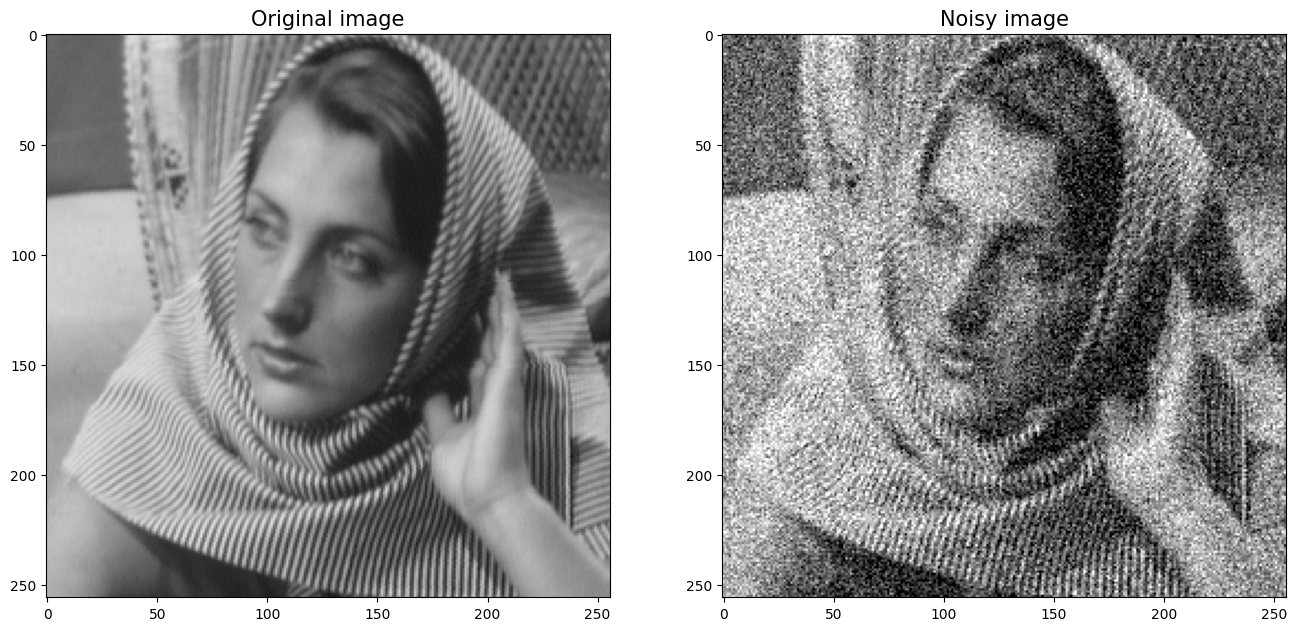

In [ ]:
# Use always the same seed for random numbers for reproducibility
np.random.seed(42)

# Simulate noisy image
sigma255 = 40
sigma1 = sigma255/255.0
noise = np.random.normal(loc=0, scale=sigma1, size=(u.shape))
utilde = u + noise

# Show original and noisy images
fig = plt.figure(figsize = (16,16))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(u, cmap = 'gray', vmin=0, vmax = 1)
ax1.set_title('Original image', fontsize = 15)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(utilde, cmap = 'gray', vmin=0, vmax = 1)
ax2.set_title('Noisy image', fontsize = 15)

### Test TV and DnCNN denoisers

Load an input image and add random gaussian noise with $\sigma_{255}=40$, 15 or 5.

Byte-encoded *gray*-scale images take values in the range [0,255].

But denoising algorithms assume that clean images take values in the range [0,1].

So you need to first normalize your clean and noisy images and sigma values to the range [0,1]:

$u_1 = u_{255}/255$

$\sigma_1 = \sigma_{255}/255$

The DnCNN denoiser can be deployed as is, but for the TV denoising you need to choose the regularization parameter $\lambda$ in

$\hat{u}_\lambda = \arg\min_u \frac{1}{2}\|u-\tilde{u}\|^2 + \lambda TV(u)$

TV Denoiser performance
residual/sigma=0.30	 RMSE=0.1197 (18.4 dB)
DnCNN Denoiser performance
residual/sigma=0.94	 RMSE=0.0450 (26.9 dB)
BM3D Denoiser performance
residual/sigma=0.95	 RMSE=0.0417 (27.6 dB)


Text(0.5, 1.0, 'BM3D denoising')

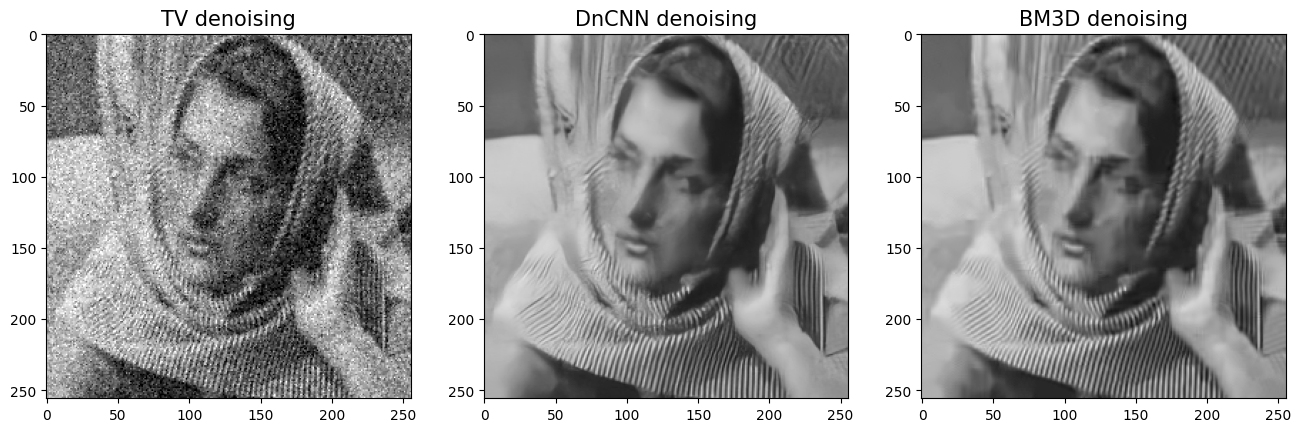

In [ ]:
from TV_denoiser import TVDenoiser
from pytorch_denoiser import PyTorchDenoiser

# TV denoiser
TVlamb = sigma1**2 #proporitonal to noise level
niter = 100
denoiser = TVDenoiser(TVlamb,niter)
uTV = denoiser.denoise(utilde)

# DnCNN denoiser
denoiser = PyTorchDenoiser('DnCNN',sigma255,cuda=True,rescale=False)
uDnCNN = denoiser.denoise(utilde)

# BM3D denoiser With the default settings.
denoiser = BM3DDenoiser(sigma255)
uBM3D = denoiser.denoise(utilde)

# Print performance and plot results
from utils.psnr import rmse, psnr
# printperf(residual, L2err)
# -- prints out residual/sigma, rmse and psnr values
# peak=np.linalg.norm(u);
peak=1.0
printperf = lambda residual,L2err : print('residual/sigma={:.2f}\t RMSE={:.4f} ({:.1f} dB)'.format(residual,L2err,20*np.log(peak/L2err)/np.log(10)))

print('TV Denoiser performance')
L2err = rmse(uTV,u) #rmse between denoised and original img
residual = rmse(uTV,utilde)
printperf(residual/sigma1, L2err)

print('DnCNN Denoiser performance')
L2err = rmse(uDnCNN,u)
residual = rmse(uDnCNN,utilde)
printperf(residual/sigma1, L2err)

print('BM3D Denoiser performance')
L2err = rmse(uBM3D,u)
residual = rmse(uBM3D,utilde)
printperf(residual/sigma1, L2err)


# Show denoised images
fig = plt.figure(figsize = (16,16))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(uTV, cmap = 'gray', vmin=0, vmax = 1)
ax1.set_title('TV denoising', fontsize = 15)
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(uDnCNN, cmap = 'gray', vmin=0, vmax = 1)
ax2.set_title('DnCNN denoising', fontsize = 15)
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(uBM3D, cmap = 'gray', vmin=0, vmax = 1)
ax3.set_title('BM3D denoising', fontsize = 15)


## Find optimal $\lambda$ for TV denoiser

The DnCNN denoiser can be deployed as is (for fixed pretrained noise values), but for the TV denoising you need to choose the regularization parameter $\lambda$ in

$\hat{u}_\lambda = \arg\min_u \frac{1}{2}\|u-\tilde{u}\|^2 + \lambda TV(u)$

Good values for $\lambda$ are usually between $\sigma$ and $\sigma^2$, but this really depends on the image contents: Total variation penalizes high frequency oscilatory patterns, so in those areas a smaller value of $\lambda$ may be required to preserve them.

A way to circumvent this problem is to systematically search for a value of $\lambda$ whose residual is close to the noise level:

$\|\hat{u}_\lambda - \tilde{u}\|^2 \approx \beta^2 \sigma^2 N$

To be conservative (we prefer to leave a bit of noise rather than removing details) we choose a value of $\beta < 1$ like $\beta=0.9$

At each iteration the value of $\lambda$ can be updated in the following manner:

$\lambda_{n+1} = \lambda_n e^{\rho(\sigma\beta - \|\hat{u}_{\lambda_n} - \tilde{u}\|/\sqrt{N})}$

This will increase or decrease $\lambda$ as needed to meet the residual constraint.

You can stop after 100 iterations or when the constraint is met up to 1% tolerance

> _**QUESTION 1**: Complete the code below as indicated_

> _**QUESTION 2**: Provide the optimal value of $\lambda$ and the RMSEs / PSNRs that you obtain for TV and the different PyTorch denoisers. Which denoiser provides the best performance?_

> _**QUESTION 3**: Is there a big difference between DnCNN and RealSN_DnCNN? Explain why or why not._



#######
quand lambda est trop grand je regulrize trop, je regarde la difference entre ce que j'attends et ce que j'ai obtenu
qlq iteration de la tv et actualize la lambda as follows:
$\lambda_{n+1} = \lambda_n e^{\rho(\sigma\beta - \|\hat{u}_{\lambda_n} - \tilde{u}\|/\sqrt{N})}$
on reiter la tv et on arrete une fois une contrainte est contrainte,, on appelle le code a convergence on calcule poui on rappelle encore

In [ ]:
print(np.sum(np.abs(noise)**2/noise.size) )
print(np.sqrt(np.sum(noise**2/noise.size)))
print(np.sqrt(noise.size* sigma1**2))
print(sigma1**2)

0.02470018661736577
0.15716293016282742
40.15686274509804
0.024605920799692427


Searching for optimal lambda for TV denoising
1
residual/sigma = 0.109	 rmse = 5.4014e-02	 lambda = 6.0248e-03
TV Denoiser performance
residual/sigma=0.19	 RMSE=0.0508 (25.9 dB)
DnCNN Denoiser performance
residual/sigma=0.89	 RMSE=0.0236 (32.5 dB)
RealSN_DnCNN Denoiser performance
residual/sigma=0.89	 RMSE=0.0236 (32.6 dB)
BM3D Denoiser performance
residual/sigma=0.87	 RMSE=0.0233 (32.7 dB)


Text(0.5, 1.0, 'RealSN_DnCNN denoising')

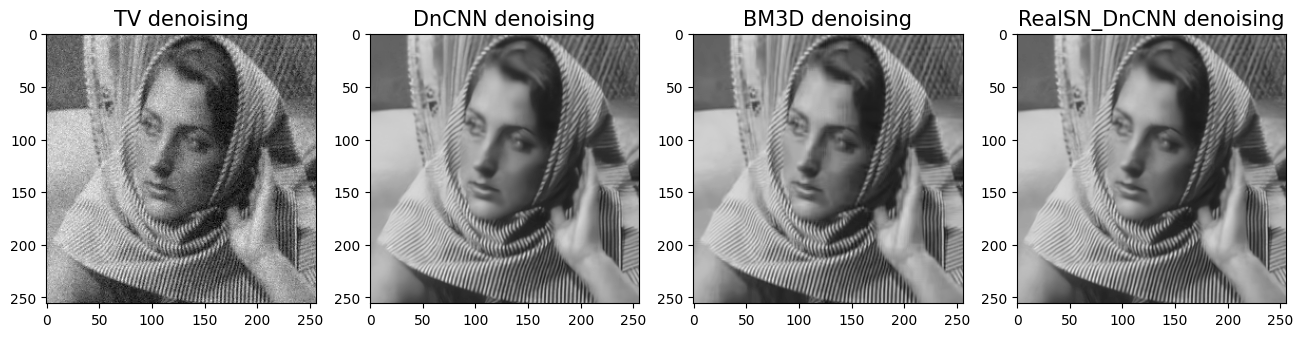

In [ ]:
# @title Default title text
sigma255 = 15
sigma1 = sigma255/255.0
noise = np.random.normal(loc=0, scale=sigma1, size=(u.shape))
utilde = u + noise

# Optimal lambda
print('Searching for optimal lambda for TV denoising')
TVlamb = sigma1**2
rho = 10
beta = 0.95
N= np.sum(np.abs(noise)**2) #power of noise
# N=noise.size
for i in range(1,100):
  print(i)
  uTV = TVDenoiser(lamb=TVlamb,niter=100).denoise(utilde)
  res = rmse(uTV,utilde)
  error = rmse(uTV,u)
  TVlamb *= np.exp(rho* (sigma1 * beta- res/np.sqrt(N))) ## COMPLETE this code
  print('residual/sigma = {:.3f}\t rmse = {:.4e}\t lambda = {:.4e}'.format((res/sigma1),error,TVlamb))
  #stop when the constraint is met up to 1% tolerance
  stop_cond= np.abs(np.sum(np.abs(uTV- utilde)**2))  >=  (beta * sigma1 * np.sqrt(N))**2   ## COMPLETE this code
  if stop_cond:
    break

# Denoise
print('TV Denoiser performance')
denoiser = TVDenoiser(TVlamb,100)
uTV = denoiser.denoise(utilde)
L2err = rmse(uTV,u)
residual = rmse(uTV,utilde)
printperf(residual/sigma1, L2err)

print('DnCNN Denoiser performance')
denoiser = PyTorchDenoiser('DnCNN',sigma255,cuda=True,rescale=False)
uDnCNN = denoiser.denoise(utilde)
L2err = rmse(uDnCNN,u)
residual = rmse(uDnCNN,utilde)
printperf(residual/sigma1, L2err)

print('RealSN_DnCNN Denoiser performance')
denoiser = PyTorchDenoiser('RealSN_DnCNN',sigma255,cuda=True,rescale=False)
uRealSN_DnCNN = denoiser.denoise(utilde)
L2err = rmse(uRealSN_DnCNN,u)
residual = rmse(uRealSN_DnCNN,utilde)
printperf(residual/sigma1, L2err)


print('BM3D Denoiser performance')
denoiser = BM3DDenoiser(sigma255)
uBM3D = denoiser.denoise(utilde)
L2err = rmse(uBM3D,u)
residual = rmse(uBM3D,utilde)
printperf(residual/sigma1, L2err)


# Show denoised images
fig = plt.figure(figsize = (16,16))
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(uTV, cmap = 'gray', vmin=0, vmax = 1)
ax1.set_title('TV denoising', fontsize = 15)
ax2 = fig.add_subplot(1,4,2)
ax2.imshow(uDnCNN, cmap = 'gray', vmin=0, vmax = 1)
ax2.set_title('DnCNN denoising', fontsize = 15)
ax3 = fig.add_subplot(1,4,3)
ax3.imshow(uBM3D, cmap = 'gray', vmin=0, vmax = 1)
ax3.set_title('BM3D denoising', fontsize = 15)
ax4 = fig.add_subplot(1,4,4)
ax4.imshow(uRealSN_DnCNN, cmap = 'gray', vmin=0, vmax = 1)
ax4.set_title('RealSN_DnCNN denoising', fontsize = 15)

## Plug & Play ADMM / DRS for Gaussian denosing

### Introduction

In the previous section TV denoising can be adapted to different values of $\sigma$ by changing the value of $\lambda$. The DnCNN denoiser, however, is pretrained for 3 fixed values of $\sigma \in \{5,15,40\}$. Now we are going to use(write) a DRS(ADMM) splitting algorithm that can denoise images with other noise levels, using the pretrained DnCNN as a regularizer.

The code allows you to solve inverse problems of the form

$
\newcommand{\prox}{{\operatorname{prox}}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\xtilde}{\mathbf{\tilde{x}}}\newcommand{\xhat}{\mathbf{\hat{x}}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\z}{\mathbf{z}}
\newcommand{\v}{\mathbf{v}}
\newcommand{\w}{\mathbf{w}}
\xhat = \arg\min_\x F(\x) + \gamma G(\x)$

or equivalently for $\gamma = \sigma^2/\alpha$

$\xhat = \arg\min_\x \alpha F(\x) + \sigma^2 G(\x)$


where
* $F$ is a ($\mu$-strongly) convex data-fitting term, and
* $G$ is a possibly non-convex regularisation term, which is not necessarily known explicitly. We only need to know its associated proximal operator
$$\prox_{\sigma^2 G}(\x) \approx D_\sigma(\x),$$ which is well approximated by the DnCNN denoiser.

The code will compute the Plug & Play ADMM algorithm to find $\xhat$.

* $ x^{k+1} = \prox_{\sigma^2 G}(y^k - u^k) $
* $ y^{k+1} = \prox_{\alpha F}(x^{k+1} + u^k) $
* $ u^{k+1} = u^k + x^{k+1} - y^{k+1} $

According to Theorem 2 and Corolary 3 this algorithm will converge as long as the residual operator $D_\sigma - I$ is $L$-Lipschitz (or $L$-contractive) with $L<1$, and the $\alpha$ parameter satisfies

$$ \alpha \mu > \frac{L}{1+L - 2L^2} $$

### Proximal operator for Gaussian denoising

For Gaussian denoising the data fitting term writes

$ F(\x) = \frac{1}{2 s^2}\| \x - \y \|^2 $

its proximal operator admits a closed form:

$ \prox_{\alpha F}(\x) = \arg\min_\v \frac12 \|\v - \x \|^2 + \alpha F(\v)
= \frac{\x + \y * \alpha / s^2}{1+\alpha/s^2}$

>_**QUESTION 4**: Complete the following code to compute $\prox_{\alpha F}$ operator for Gaussian denoising._

In [ ]:
#%% ---- define problem-specific proxF ----

def prox_datafit_gaussian_denoising(x, y, alpha, s):
    """
    Proximal Operator for Gaussian denoising:

    f(x) = || x - y ||^2 / (2 s^2)

    prox_{alpha f} (x) = (x + y*alpha/s^2)/(1+alpha/s^2)

    Parameters:
        :x - the argument to the proximal operator.
        :y - the noisy observation (flattened).
        :opts - the kwargs for hyperparameters.
            :alpha - the value of alpha.
            :s - the standard deviation of the gaussian noise in y.
    """
    a = alpha/(s**2)
    v = (x + y*a)/(1+a) # COMPLETE this code
    return v




### PnP DRS denoising experiment with $s = \sigma$


Now use the provided PnP DRS algorithm to denoise an image with noise variance $s^2 = \sigma^2$.

In this case you should use the regularization parameter $\gamma = 1$.

i = 1,	 psnr = 26.965323130272235,	 fpr = 0.14760314073924402
i = 2,	 psnr = 26.965323130272235,	 fpr = 0.07380157036962201
i = 3,	 psnr = 26.965323130272235,	 fpr = 0.036900785184811005
i = 4,	 psnr = 26.965323130272235,	 fpr = 0.018450392592405503
i = 5,	 psnr = 26.965323130272235,	 fpr = 0.00922519629620275
i = 6,	 psnr = 26.965323130272235,	 fpr = 0.004612598148101376
i = 7,	 psnr = 26.965323130272235,	 fpr = 0.002306299074050688
i = 8,	 psnr = 26.965323130272235,	 fpr = 0.001153149537025344
i = 9,	 psnr = 26.965323130272235,	 fpr = 0.000576574768512672
i = 10,	 psnr = 26.965323130272235,	 fpr = 0.000288287384256336


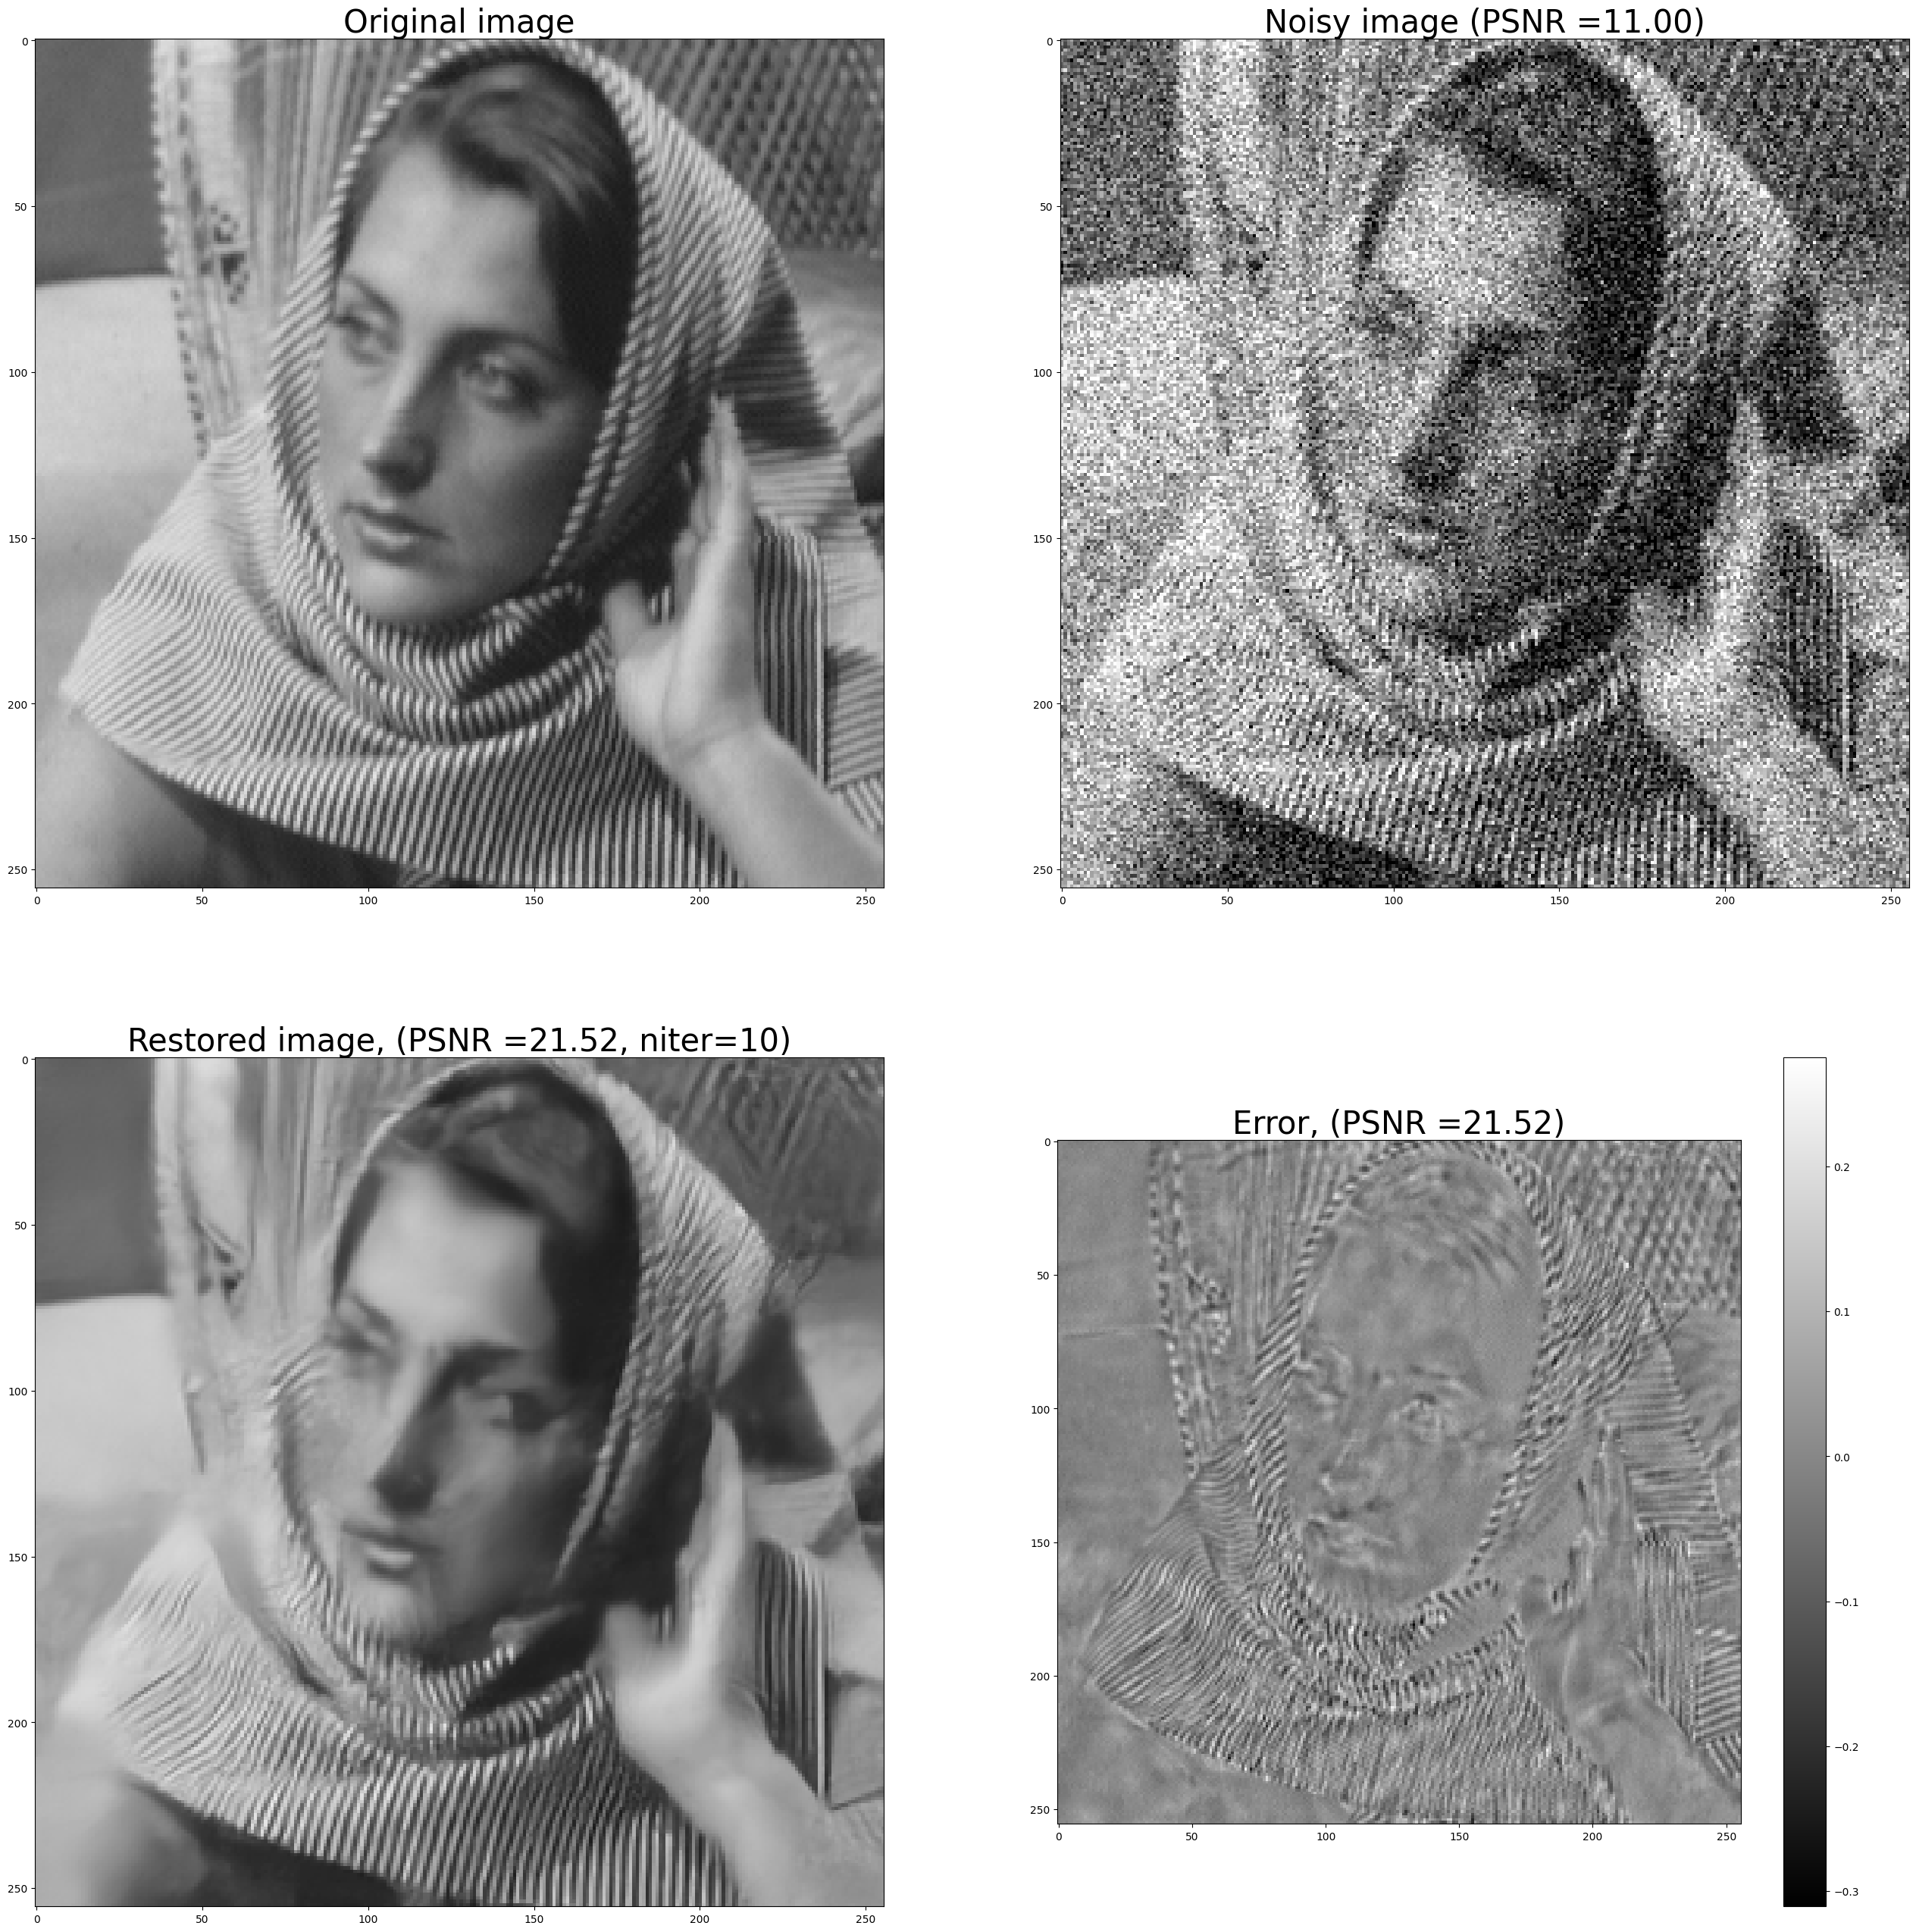

In [ ]:
# @title set parameters & run denoisig experiment

sigma255=40 # @param [5, 15, 40] {type:"raw"}
gamma=1.0 # @param {type:"number"}
maxitr=10 # @param {type:"slider", min:10, max:100, step:10}

# ---- Regularization model prox_{sigma^2 G} = denoise ----
# noise level
#sigma255 = 40             # for uint8 images
sigma1 = sigma255/255.0   # for images normalized in [0,1]
# load pretrained denoiser NN model into Denoiser object
model_type = "RealSN_DnCNN"     # Alternatives: DnCNN/ SimpleCNN / RealSN_DnCNN / RealSN_SimpleCNN
sigma = sigma255                # Alternatives: 5, 15, 40
cuda = True                     # If true use pytorch cuda optimisations
rescale = False                 # If true rescale [min,max] to [0,1] before applying denoiser
Denoiser = PyTorchDenoiser(model_type,sigma,cuda,rescale)
# define denoise(x) function (as a call to the Denoiser object)
denoise = lambda x : Denoiser.denoise(x)

# ADMM / DRS parameters
#gamma = 1.0                       # Regularization parameter
alpha = sigma1**2/gamma
#maxitr = 20                     # ADMM max number of iterations
# Monitors
verbose = 1                     # display debugging messages
from optim import drs, GaussianMonitor
monitor = GaussianMonitor(u) # ground truth is only used
                             # to track PSNR during iterations

# Set noise variance s^2 equal to denoiser variance sigma^2
s = sigma1

# Datta fitting : prox_{alpha F}
proxF = lambda x : prox_datafit_gaussian_denoising(x, utilde, alpha, s)



# optional PnP DRS/ADMM parameters
opts = dict(maxitr=maxitr,
            verbose=verbose,
            monitor=monitor)


# ---- simulate noisy image ----
np.random.seed(42) # Use always the same seed for reproducibility
s = sigma1
noise = np.random.normal(loc=0, scale=s, size=(u.shape))
utilde = u + noise


# Start the algorithm
#start = time.time()
init = utilde
#init = np.random.normal(loc=0.5, scale=0.5, size=(noisy.shape))
out = drs(proxF,denoise,init,**opts)
#out = admm(proxF,denoise,init,**opts)
#end = time.time()
#print(end-start)

#%% ---- plot result ----
fig = plt.figure(figsize = (32,32))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(u, cmap = 'gray', vmin=0, vmax = 1)
ax1.set_title('Original image', fontsize = 30)

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(utilde, cmap = 'gray', vmin=0, vmax = 1)
ax2.set_title('Noisy image (PSNR ={0:.2f})'.format(psnr(u, utilde)), fontsize = 30)

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(out, cmap ='gray', vmin= 0, vmax=1)
ax3.set_title(r'Restored image, (PSNR ={0:.2f}, niter={1})'.format(psnr(u, out),maxitr), fontsize = 30)

ax4 = fig.add_subplot(2,2,4)
p = ax4.imshow(out-u, cmap ='gray')
plt.colorbar(p,orientation='vertical')
_ = ax4.set_title(r'Error, (PSNR ={0:.2f})'.format(psnr(u, out)), fontsize = 30)



### PnP DRS denoising experiment with $s \neq \sigma$

Now use the provided PnP DRS algorithm to denoise an image with noise variance $s^2 \neq \sigma^2$.

In this case the regularization parameter $\gamma$ needs to be adapted to find the optimal value.

>_**QUESTION 5:** Take $s=30$ and use the same strategy as for TV denoising to search for the optimal $\gamma$ for $\sigma=5, 15, 40$. Make a table with the optimal values of $\gamma$ for each $\sigma$ and the corresponding PSNRs._
1. _What is the maximum value of $\gamma$ that ensures convergence?_
2. _Is convergence guaranteed in all cases? Which ones?_
3. _Which value of $\sigma$ provides the best results? Can you explain why?_

A partial answer to the convergence analysis is provided in the cell below

>_**QUESTION 6:** Compare the results obtained with RealSN_DnCNN and with DnCNN, TV and BM3D. Which one provides the best performance? Can you explain why?_

>_**QUESTION 7:** Test different initialisations, including 0 and random images. How important is the initialization to obtain a good result? Is this consistent with the convergence results seen in the Lecture ?_


| $\sigma$ | $\gamma$ | PSNR |
| -------- | -------- | ---- |
| 40 | 1.36 | 22.91 dB |


In [ ]:
from optim import admm
from utils.psnr import rmse, psnr
# u = normalized input image (defined above)

# ---- Degradation model F (white gaussian noise) ----
s = 30.0
s1 = s / (maxval-minval)
np.random.seed(42)
noise = np.random.normal(loc=0, scale=s1, size=(u.shape))
utilde = u + noise


# ---- Regularization model prox_{sigma^2 G} = denoise ----
# Denoiser noise level - Alternatives: 5, 15, 40
sigma255 = 5              # for uint8 images
sigma1 = sigma255/255.0   # for images normalized in [0,1]
# load pretrained denoiser NN model into Denoiser object
model_type = "RealSN_DnCNN"     # Alternatives: DnCNN/ SimpleCNN / RealSN_DnCNN / RealSN_SimpleCNN
sigma = sigma255                # Alternatives: 5, 15, 40
cuda = True                     # If true use pytorch cuda optimisations
rescale = False                 # If true rescale [min,max] to [0,1] before applying denoiser
# pytorch deoiser
Denoiser = PyTorchDenoiser(model_type,sigma,cuda,rescale)
# define denoise(x) function (as a call to the Denoiser object)
denoise = lambda x : Denoiser.denoise(x)



# ADMM / DRS parameters
gamma = sigma1/s1                   # Regularization parameter
alpha = sigma1**2/gamma
maxitr = 100                    # ADMM max number of iterations
# Monitors
verbose = 0                     # display debugging messages

proxF = lambda x : prox_datafit_gaussian_denoising(x, utilde, alpha, s1)


# COMPLETE THE CODE
# find optimal gamma
# compute out = result of PnP ADMM denoising
# repeat for sigma255 = 40, 15, 5

# begin ANSWER
def get_best_gamma(utilde, u, maxiter, sigma255, s1, model_type="DnCNN", init=None):
    opts = dict(maxitr=1,
            verbose=verbose,
            monitor=monitor)

    sigma1 = sigma255 / 255.0
    gamma = sigma1 / s1  # Initial regularization parameter
    best_gamma = gamma
    best_psnr = 0
    delta_ = float('inf')

    # Initialize the PyTorch denoiser

    # Initialize variables for PnP ADMM
    x = np.copy(utilde) if init is None else init.copy()
    y = np.copy(x)
    u_k = np.zeros_like(utilde, dtype=np.float64)
    # print('Using: {} denoiser'.format(model_type))
    for i in range(maxiter):
        alpha = sigma1**2 / gamma

        if model_type== 'BM3DDenoiser':
          Denoiser = BM3DDenoiser(sigma255)
        elif model_type== 'TVDenoiser':
          Denoiser= TVDenoiser(gamma,100)
        else:
          Denoiser = PyTorchDenoiser(model_type, sigma255, True, False)

        denoise = lambda x : Denoiser.denoise(x)

        x_next = admm(proxF, denoise, utilde, **opts)

        # Calculate PSNR and update the best gamma if needed
        current_psnr = psnr(x_next, u)
        if current_psnr > best_psnr:
            best_psnr = current_psnr
            best_gamma = gamma

        # Update gamma based on the residual performance
        # Calculate PSNR and update the best gamma if needed
        current_psnr = psnr(x_next, u)
        if current_psnr > best_psnr:
            best_psnr = current_psnr
            best_gamma = gamma

        # Update gamma based on the residual performance
        delta_n = np.linalg.norm(x_next - x)
        if delta_n >= delta_:
            gamma = 1.1* gamma  # Increase gamma
            delta_ = delta_n
        if delta_n< delta_:
          gamma = 0.9 * gamma
          delta_= delta_n

    return best_gamma, best_psnr

In [ ]:
sigma_values = [5, 15, 40]
for sigma255 in sigma_values:
    best_gamma, best_psnr = get_best_gamma(utilde, u, 100, sigma255, s1, "TVDenoiser")
    print(f"for sigma = {sigma255},  best gamma is {best_gamma} with PSNR = {best_psnr}")

# end ANSWER

Using: TVDenoiser denoiser
for sigma = 5,  best gamma is 0.16666666666666666 with PSNR = 18.005970128159426
Using: TVDenoiser denoiser
for sigma = 15,  best gamma is 0.5 with PSNR = 15.882845505491535
Using: TVDenoiser denoiser
for sigma = 40,  best gamma is 1.3333333333333333 with PSNR = 14.036522787882848


In [ ]:
#for question 7 testing with different initializations
from utils.psnr import rmse, psnr
def test_init(utilde, u, maxiter, sigma255, s1, model_type="DnCNN"):
  #initializations
  inits={
      "zeros": np.zeros_like(utilde),
      "random": np.random.rand(*utilde.shape),
      "noisy": np.copy(utilde)
  }
  results={}
  for name_init, init in inits.items():
    best_gamma, best_psnr= get_best_gamma(utilde, u, 50, sigma255, s1, model_type=model_type , init = init)
    results[name_init] = (best_gamma, best_psnr)
  return results

sigma_values = [5, 15, 40]
models=["DnCNN", "TVDenoiser"]
for model in models:
  print('mode: ', model)
  for sigma255 in sigma_values:
      results = test_init(utilde, u, 100, sigma255, s1, model_type=model)
      for init_type, (gamma, best_psnr) in results.items():
          print(f"Sigma = {sigma255}, Init = {init_type}, Best Gamma = {gamma}, PSNR = {best_psnr}")

mode:  DnCNN
Sigma = 5, Init = zeros, Best Gamma = 0.16666666666666666, PSNR = 13.395610353753028
Sigma = 5, Init = random, Best Gamma = 0.16666666666666666, PSNR = 13.395610353753028
Sigma = 5, Init = noisy, Best Gamma = 0.16666666666666666, PSNR = 13.395610353753028
Sigma = 15, Init = zeros, Best Gamma = 0.5, PSNR = 15.287718248299477
Sigma = 15, Init = random, Best Gamma = 0.5, PSNR = 15.287718248299477
Sigma = 15, Init = noisy, Best Gamma = 0.5, PSNR = 15.287718248299477
Sigma = 40, Init = zeros, Best Gamma = 1.3333333333333333, PSNR = 21.532016296692888
Sigma = 40, Init = random, Best Gamma = 1.3333333333333333, PSNR = 21.532016296692888
Sigma = 40, Init = noisy, Best Gamma = 1.3333333333333333, PSNR = 21.532016296692888
mode:  TVDenoiser
Sigma = 5, Init = zeros, Best Gamma = 0.16666666666666666, PSNR = 18.005970128159426
Sigma = 5, Init = random, Best Gamma = 0.16666666666666666, PSNR = 18.005970128159426
Sigma = 5, Init = noisy, Best Gamma = 0.16666666666666666, PSNR = 18.005970

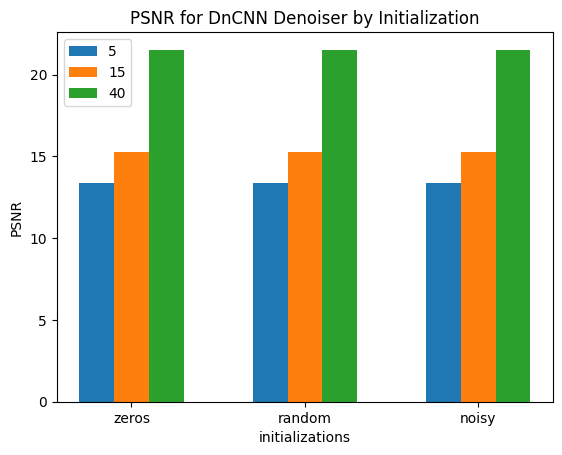

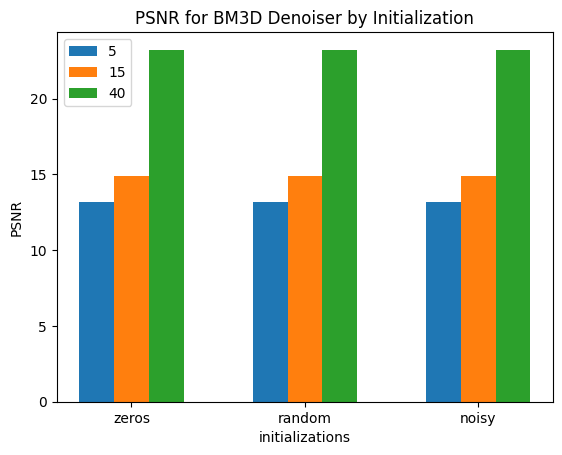

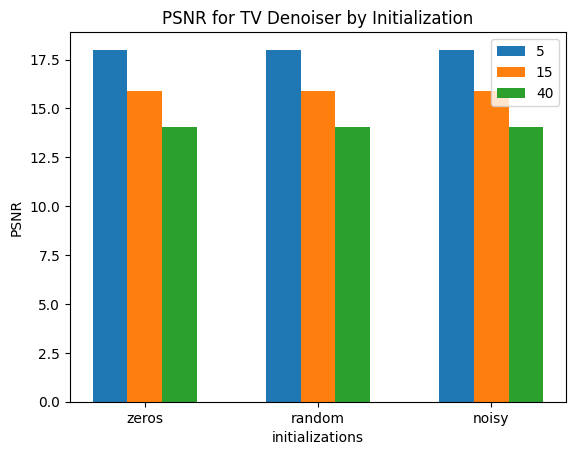

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
denoisers = ['DnCNN', 'BM3D', 'TV']
sigmas = [5, 15, 40]
psnr_dncnn = [13.39, 15.28, 21.53, 13.39, 15.28, 21.53, 13.39, 15.28, 21.53]
psnr_bm3d = [13.21, 14.89, 23.23, 13.21, 14.89, 23.23, 13.21, 14.89, 23.23]
psnr_tv = [18.00, 15.88, 14.03, 18.00, 15.88, 14.03, 18.00, 15.88, 14.03]

# Function to create the plot for each denoiser with correct PSNR values
def create_correct_plot(denoiser_name, psnr_values):
    fig, ax = plt.subplots()

    # Each group of bars will have 3 bars (for each initialization type)
    bar_width = 0.2
    inits= ['zeros', 'random', 'noisy']
    index = np.arange(len(inits))

    # Plotting each initialization type
    for i, sigma in enumerate(sigmas):
        ax.bar(index + i * bar_width, psnr_values[i::3], bar_width, label=f'{sigma}')

    # Adding labels and title
    ax.set_xlabel('initializations')
    ax.set_ylabel('PSNR')
    ax.set_title(f'PSNR for {denoiser_name} Denoiser by Initialization')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(inits)
    ax.legend()

    plt.show()

# Creating and displaying the plots
create_correct_plot('DnCNN', psnr_dncnn)
create_correct_plot('BM3D', psnr_bm3d)
create_correct_plot('TV', psnr_tv)


i = 1,	 psnr = 18.828554251340183,	 fpr = 0.0055551238840881745
i = 2,	 psnr = 18.995880805934892,	 fpr = 0.0036037926906365763
i = 3,	 psnr = 19.13888082981462,	 fpr = 0.002797879889592865
i = 4,	 psnr = 19.26323370839911,	 fpr = 0.0023370074031700237
i = 5,	 psnr = 19.372138922739325,	 fpr = 0.0019963734385583
i = 6,	 psnr = 19.467834340703366,	 fpr = 0.001724662758715522
i = 7,	 psnr = 19.552105568560627,	 fpr = 0.0015005768779573344
i = 8,	 psnr = 19.626437283472256,	 fpr = 0.0013121489050266838
i = 9,	 psnr = 19.692076473796945,	 fpr = 0.0011514913488991565
i = 10,	 psnr = 19.750089294368724,	 fpr = 0.00101307919814623
i = 11,	 psnr = 19.801396039290232,	 fpr = 0.0008932224246985924
i = 12,	 psnr = 19.84679688310798,	 fpr = 0.0007889845656362227
i = 13,	 psnr = 19.88699317189482,	 fpr = 0.0006979866698612005
i = 14,	 psnr = 19.92259957077042,	 fpr = 0.0006184187590554074
i = 15,	 psnr = 19.954153414298403,	 fpr = 0.0005486821148207537
i = 16,	 psnr = 19.982127077803135,	 fpr = 0.0

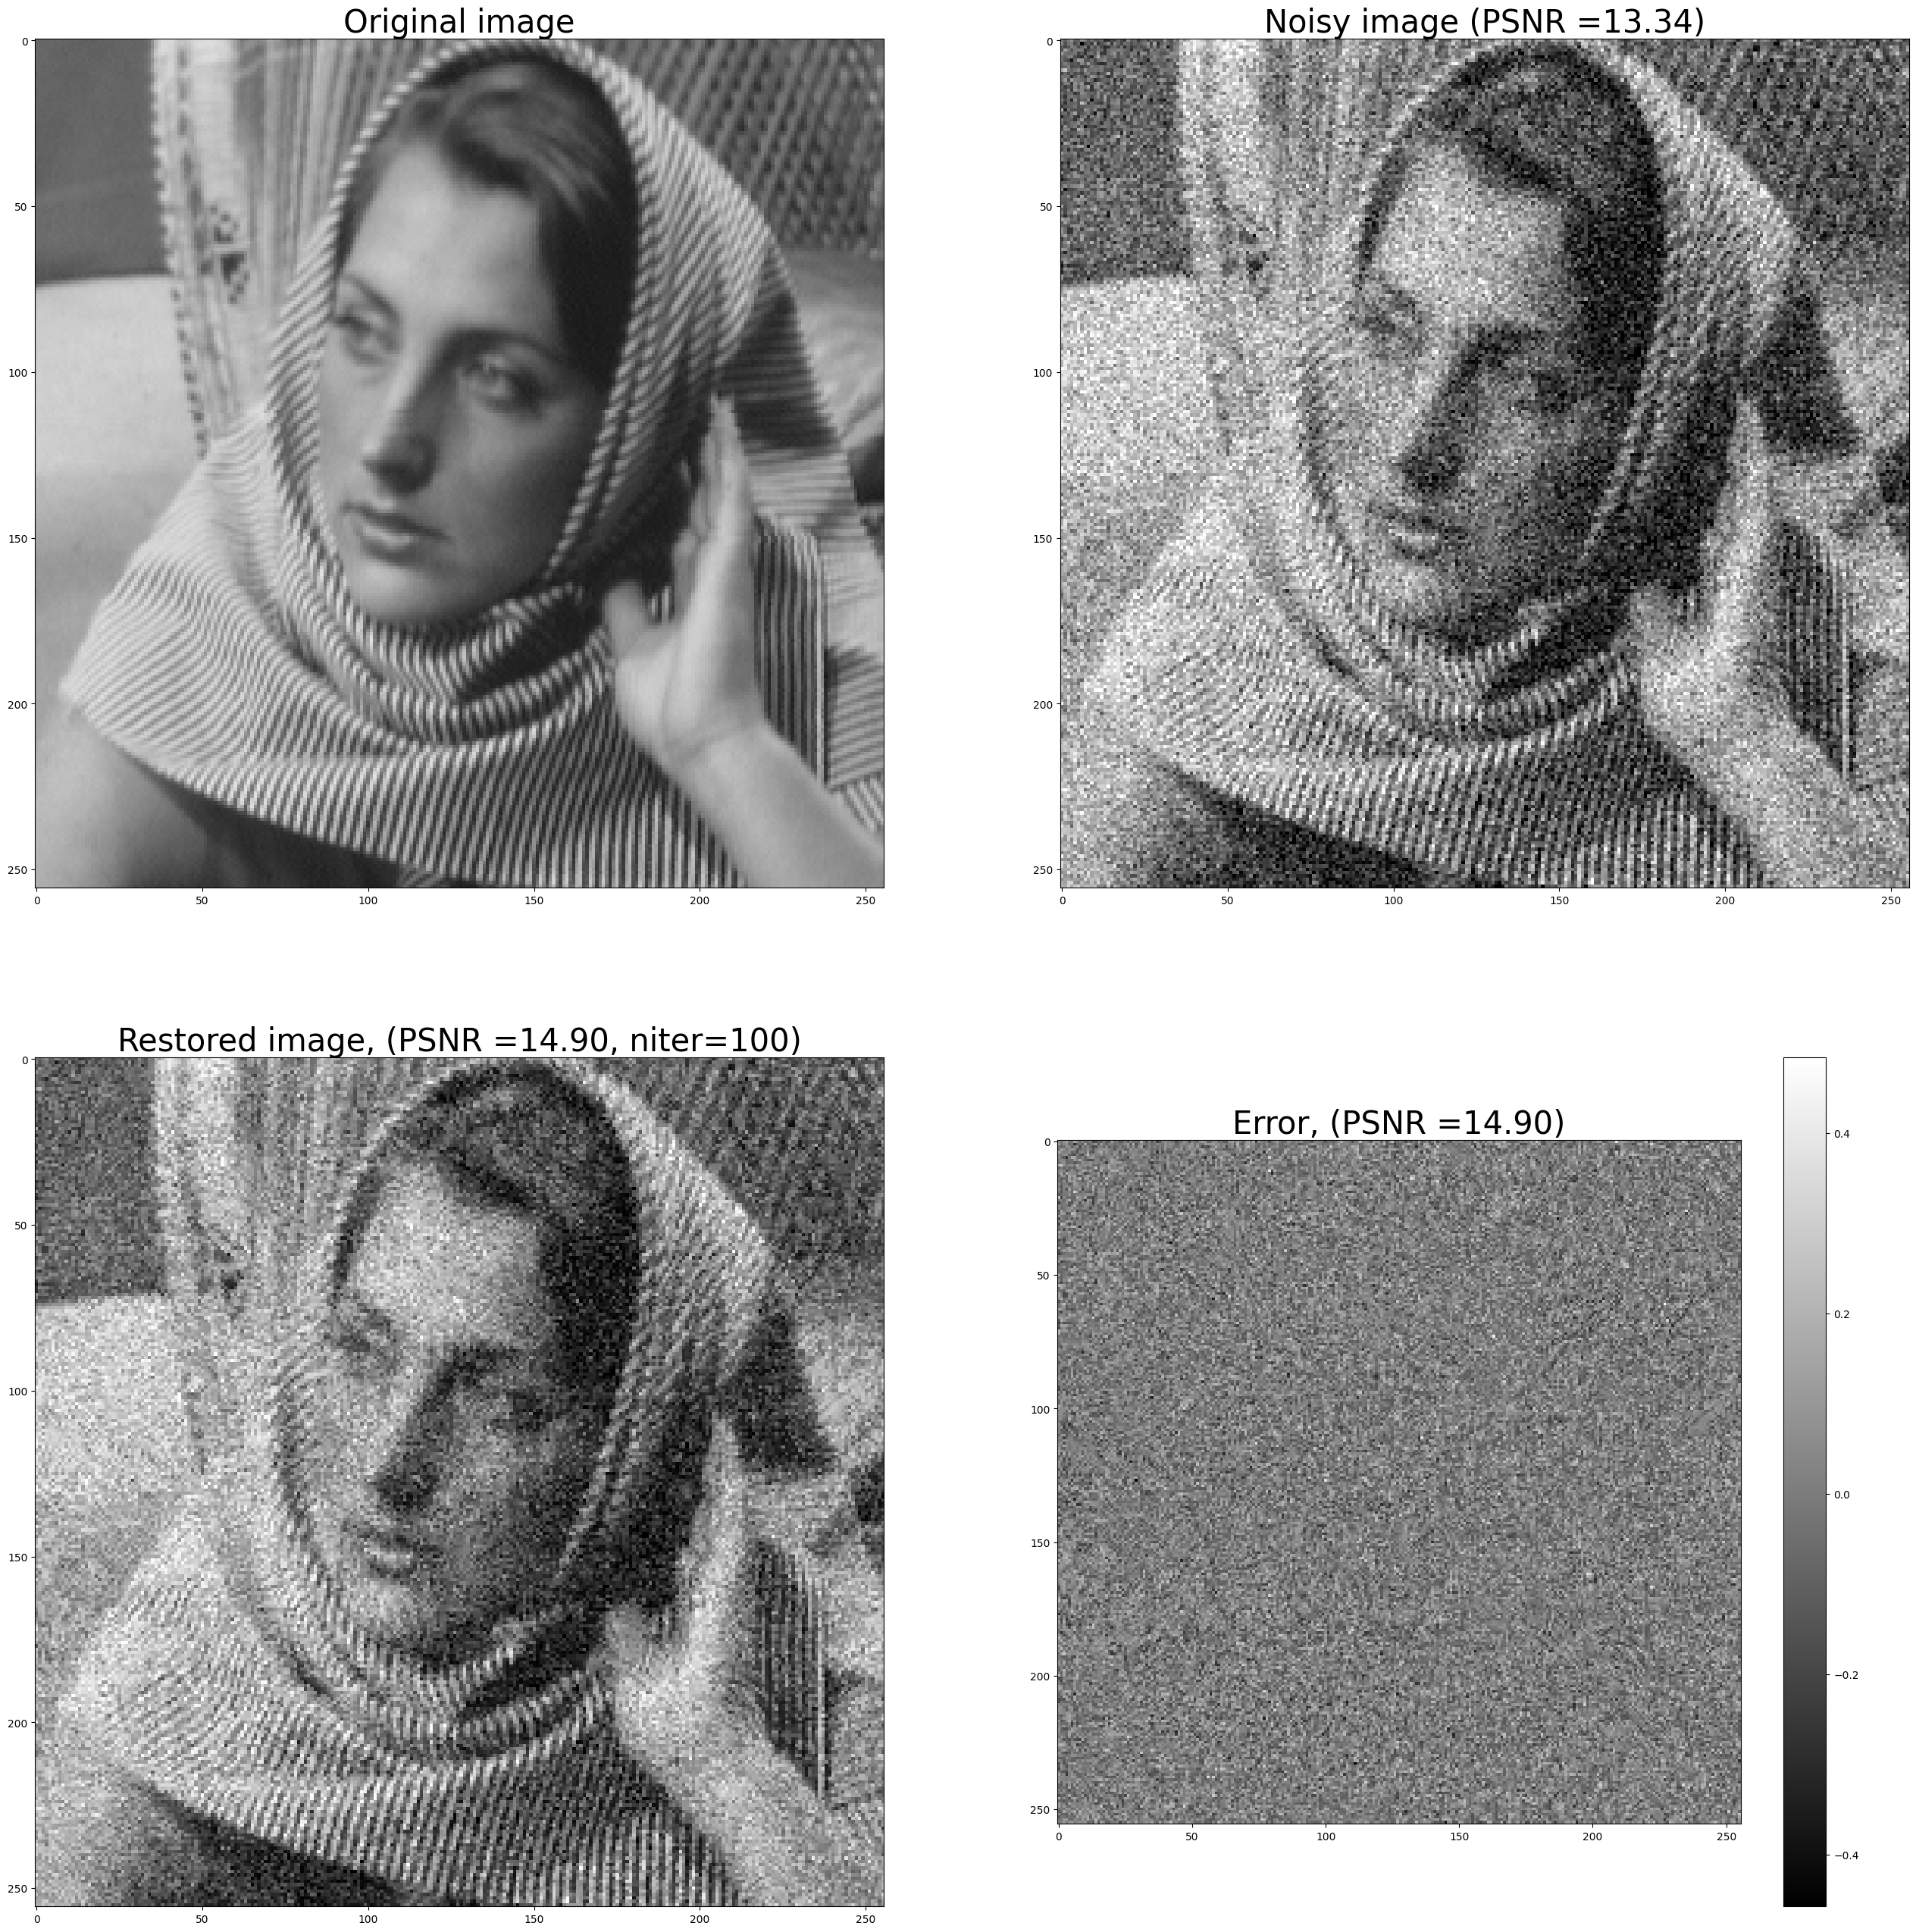

In [ ]:
# ---- optional ADMM parameters ----
monitor = GaussianMonitor(u)
opts = dict(maxitr=maxitr,
            verbose=1,
            monitor=monitor)

#%% ---- plug and play !!!! ----
out = drs(proxF,denoise,utilde,**opts)
# out = admm(proxF,denoise,utilde,**opts)


#%% ---- plot result ----
fig = plt.figure(figsize = (32,32))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(u, cmap = 'gray', vmin=0, vmax = 1)
ax1.set_title('Original image', fontsize = 30)

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(utilde, cmap = 'gray', vmin=0, vmax = 1)
ax2.set_title('Noisy image (PSNR ={0:.2f})'.format(psnr(u, utilde)), fontsize = 30)

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(out, cmap ='gray', vmin= 0, vmax=1)
ax3.set_title(r'Restored image, (PSNR ={0:.2f}, niter={1})'.format(psnr(u, out),maxitr), fontsize = 30)

ax4 = fig.add_subplot(2,2,4)
p = ax4.imshow(out-u, cmap ='gray')
plt.colorbar(p,orientation='vertical')
_ = ax4.set_title(r'Error, (PSNR ={0:.2f})'.format(psnr(u, out)), fontsize = 30)

### Check convergence conditions


The PnP-ADMM algorithm for minimizing $\alpha F(x) + \sigma^2 G(x)$ is guaranteed to converge to a fixed point as long as:
* $F$ is $\mu$-strongly convex
* $Lip(I-D) = L < 1$ where $D=\prox_{\sigma^2 G}$ is the denoiser
* The regularization parameter $\gamma = \sigma^2/\alpha$ satisfies
$$ \gamma < \mu \sigma^2 \frac{1+L - 2 L^2}{L}$$

For the denoising problem we have
$$ F(x) = \frac{\|x - y\|^2}{2s^2} $$

**Find the maximal value of $\mu$ such that $F$ is $\mu$ strongly convex**

$F$ is $\mu$-strongly convex iff $\nabla^2 F - \mu Id$ is positive semidefinite, i.e. iff $(\frac{1}{s^2}-\mu)Id$ posite semidefinite. $\mu = \frac{1}{s^2}$

The _estimated_ value of $Lip(I-D) = L$ for the different denoisers is, according to Ryu(2019, Figure 1)

| $D$   | $L$ |
| ----- | ---------- |
| RealSN_DnCNN | 0,464 |
| DnCNN | 0,484 |
| BM3D  | 1,198 |

You can write a variant of the DRS algorithm which tracks the expansion factor at each iteration of the of the PnP-DRS algorithm.
Let $T$ be the operator that computes one iteration of PnP-DRS.

$$ u_{k+1} = T(u_k) $$

The algorithm converges to a fixed point $u^*$ if $T(u^*)=u^*$.
This convergence is ensures as long as $T$ is nonexpansive meaning that

$$ \|T(x) - T(y)\| \leq \varphi \|x-y\| \quad \forall x, y \quad \text{ and } \varphi <1 $$

The expansion factor $\varphi$ can be estimated as the maximal value of

$$ \varphi_k = \|T(x_k) - T(x_{k-1}) \| / \|x_k - x_{k-1}\| $$

$x_k = T(x_{k-1})$

complete the code below to output an array factors with these estimates



In [ ]:

def drs2(proxF,proxG,init,**opts):
    """
    Douglas Rachford Splitting (notation differs from Ryu's paper as follows)
    zk     = x_old + u_old
    xk+1/2 = v
    xk+1   = x
    This variant tracks the contraction factors at each iteration
    """

    """ Process parameters. """
    maxitr = opts.get('maxitr', 50)
    verbose = opts.get('verbose', 1)
    monitor  = opts.get('monitor', None)  # debugging messages


    """ Initialization. """

    n = init.size  # == np.prod(init.shape), i.e. number of elements in ndarray

    x = np.copy(init)
    v = np.zeros_like(init, dtype=np.float64)
    u = np.zeros_like(init, dtype=np.float64)
    x_old = np.zeros_like(init, dtype=np.float64)

    factors = np.zeros([maxitr-1], dtype=np.float64)

    """ Main loop. """

    for i in range(maxitr):

        # record the variables in the current iteration
        x_older = np.copy(x_old)
        x_old = np.copy(x)
        v_old = np.copy(v)
        u_old = np.copy(u)

        """ proximal step. """

        v = proxF(x+u)
        # prox_poisson_datafit(x+u,noisy,lam)

        """ denoising step. """

        xtilde = np.copy(2*v - x_old - u_old)
        #x = denoiser(np.reshape(xtilde, (m,n)))
        #x = np.reshape(x, -1)
        x = proxG(xtilde)

        """ dual update """

        u = np.copy(u_old + x_old - v)

        """ Monitors """

        if verbose and not (monitor is None) :
            monitor.drs_iter(i,x,v,u,x_old,v_old,u_old)

        if (i>0):
          factors[i-1]= np.linalg.norm(x-x_old)/np.linalg.norm(x_old-x_older)

    """ Get restored image. """
    #x = np.reshape((x) , (m, n))
    return x , factors




# u = normalized input image (defined above)

# ---- Degradation model F (white gaussian noise) ----
s = 30.0
s1 = s / (maxval-minval)
np.random.seed(42)
noise = np.random.normal(loc=0, scale=s1, size=(u.shape))
utilde = u + noise


# ---- Regularization model prox_{sigma^2 G} = denoise ----
# noise level
sigma255 = 15             # for uint8 images
sigma1 = sigma255/255.0   # for images normalized in [0,1]
# load pretrained denoiser NN model into Denoiser object
model_type = "RealSN_DnCNN"     # Alternatives: DnCNN/ SimpleCNN / RealSN_DnCNN / RealSN_SimpleCNN
#model_type = "DnCNN"     # Alternatives: DnCNN/ SimpleCNN / RealSN_DnCNN / RealSN_SimpleCNN
sigma = sigma255                # Alternatives: 5, 15, 40
cuda = True                     # If true use pytorch cuda optimisations
rescale = False                 # If true rescale [min,max] to [0,1] before applying denoiser
# Pytorch denoiser
Denoiser = PyTorchDenoiser(model_type,sigma,cuda,rescale)
# BM3D denoiser
# Denoiser = BM3DDenoiser(sigma255)
# define denoise(x) function (as a call to the Denoiser object)
denoise = lambda x : Denoiser.denoise(x)


# ADMM / DRS parameters
gamma0 = sigma1/s1                   # Regularization parameter
alpha = sigma1**2/gamma
maxitr = 20                    # ADMM max number of iterations
# Monitors
verbose = 0                     # display debugging messages

proxF = lambda x : prox_datafit_gaussian_denoising(x, noisy, alpha, s1)


# Maximal (theoretical) gamma
mu = 1.0/(s1**2)
eps = 0.464 # RealSN_DnCNN
#eps = 1.198 # BM3D
gamma_max = mu*(sigma1**2)*(1.0+eps-2*(eps**2))/eps

# geometric mean
gmean = lambda a: np.exp(np.mean(np.log(a)))

init = utilde
print('Theoretical gamma max = {:.3e}'.format(gamma_max))
# test a few gammas around the approximately optimal gamma
for factor in np.geomspace(1/4,8,num=10):
  gamma = gamma0 * factor
  alpha = sigma1**2/gamma
  opts = dict(maxitr=maxitr, verbose=0, monitor=None)
  # Datta fitting : prox_{alpha F}
  proxF = lambda x : prox_datafit_gaussian_denoising(x, utilde, alpha, s1)
  out,factors = drs2(proxF,denoise,init,**opts)
  res = rmse(out,utilde)
  error = rmse(out,u)
  gamma = gamma*np.exp(rho*(s1*beta-res))
  print('residual/sigma = {:.3f}\t rmse = {:.3e}\t gamma = {:.3e}\t max eps = {:.2f}\t mean eps = {:.2f}'.format((res/s1),error,gamma,np.max(factors),gmean(factors)))
  stop_cond = (np.abs(s1*beta-res)<s1*0.005)
  if stop_cond:
    break


Theoretical gamma max = 5.568e-01
residual/sigma = 0.118	 rmse = 1.060e-01	 gamma = 3.328e-01	 max eps = 0.74	 mean eps = 0.48
residual/sigma = 0.176	 rmse = 1.001e-01	 gamma = 4.569e-01	 max eps = 0.94	 mean eps = 0.47
residual/sigma = 0.273	 rmse = 9.020e-02	 gamma = 5.985e-01	 max eps = 0.65	 mean eps = 0.48
residual/sigma = 0.493	 rmse = 6.981e-02	 gamma = 6.798e-01	 max eps = 0.79	 mean eps = 0.72
residual/sigma = 0.949	 rmse = 3.641e-02	 gamma = 5.840e-01	 max eps = 0.94	 mean eps = 0.82


### PnP ADMM algorithm

>_**QUESTION 8:**_
>
>_a) write the ADMM algorithm to solve $\xhat = \arg\min_\x F(\x) + G(\x)$ given the proximal operators of $F$ and $G$. (You can use the provided Douglas Rachford algorithm, which is very similar and equivalent to ADMM, or the code squeleton below)._
>
>_b) A renaming of variables with a reordering of the three updates allows to show the equivalence of ADMM and DRS. Prove this equivalence._




In [ ]:
def admm2(proxF,proxG,init,**opts):
    """
    ADMM - min_x F(x) + G(x) by ADMM splitting
    Inputs:
        :proxF      Proximal operator of F
        :proxG      Proximal operator of G
        :init       Initial value of x
    Optional inputs
        :maxitr     default 50
        :verbose    default 1 (show messages)
        :monitor    default None
    Outputs
        :x          minimizer
    """

    """ Process parameters. """
    maxitr = opts.get('maxitr', 50)
    verbose = opts.get('verbose', 1)
    monitor  = opts.get('monitor', None)  # debugging messages


    """ Initialization. """

    n = init.size  # == np.prod(init.shape), i.e. number of elements in ndarray

    y = np.copy(init)
    x = np.zeros_like(init, dtype=np.float64)
    u = np.zeros_like(init, dtype=np.float64)
    x_old = np.zeros_like(init, dtype=np.float64)
    factors = np.zeros(maxitr-1, dtype=np.float64)
    """ Main loop. """

    for i in range(maxitr):

        # record the variables in the current iteration
        x_older = np.copy(x_old)
        x_old = np.copy(x)
        y_old = np.copy(y)
        u_old = np.copy(u)

        """ denoising step. """
        x = proxG(y - u)

        """ proximal step. """

        y = proxF(x + u)

        """ dual update """

        u = u_old + x - y

        if i > 0:
            factors[i-1] = np.linalg.norm(x - x_old) / np.linalg.norm(x_old - x_older)

        """ Monitors """

        if verbose and not (monitor is None) :
            monitor.admm_iter(i,x,y,u,x_old,y_old,u_old)

    """ Get restored image. """
    return x, factors

# test a few gammas around the approximately optimal gamma
for factor in np.geomspace(1/4,8,num=10):
  gamma = gamma0 * factor
  alpha = sigma1**2/gamma
  opts = dict(maxitr=maxitr, verbose=0, monitor=None)
  # Datta fitting : prox_{alpha F}
  proxF = lambda x : prox_datafit_gaussian_denoising(x, utilde, alpha, s1)
  out,factors = admm2(proxF,denoise,init,**opts)
  res = rmse(out,utilde)
  error = rmse(out,u)
  gamma = gamma*np.exp(rho*(s1*beta-res))
  print('residual/sigma = {:.3f}\t rmse = {:.3e}\t gamma = {:.3e}\t max eps = {:.2f}\t mean eps = {:.2f}'.format((res/s1),error,gamma,np.max(factors),gmean(factors)))
  stop_cond = (np.abs(s1*beta-res)<s1*0.005)
  if stop_cond:
    break

residual/sigma = 0.296	 rmse = 5.068e-01	 gamma = 3.673e-01	 max eps = 0.86	 mean eps = 0.62
residual/sigma = 0.412	 rmse = 5.056e-01	 gamma = 5.042e-01	 max eps = 0.85	 mean eps = 0.60
residual/sigma = 0.549	 rmse = 5.040e-01	 gamma = 6.838e-01	 max eps = 0.75	 mean eps = 0.54
residual/sigma = 0.683	 rmse = 5.022e-01	 gamma = 9.285e-01	 max eps = 0.82	 mean eps = 0.45
residual/sigma = 0.815	 rmse = 4.997e-01	 gamma = 1.263e+00	 max eps = 0.63	 mean eps = 0.48
residual/sigma = 0.964	 rmse = 4.967e-01	 gamma = 1.701e+00	 max eps = 0.92	 mean eps = 0.68
residual/sigma = 1.137	 rmse = 4.930e-01	 gamma = 2.257e+00	 max eps = 1.08	 mean eps = 0.76
residual/sigma = 1.323	 rmse = 4.888e-01	 gamma = 2.973e+00	 max eps = 1.12	 mean eps = 0.79
residual/sigma = 1.509	 rmse = 4.836e-01	 gamma = 3.918e+00	 max eps = 1.01	 mean eps = 0.80
residual/sigma = 1.677	 rmse = 4.777e-01	 gamma = 5.215e+00	 max eps = 1.04	 mean eps = 0.81


## Missing Pixels

Another common inverse problem is missing pixels where the observation model is

$$ y_i = m_i x_i + n_i$$

where $m_i \sim \operatorname{Ber}(p)$ is known
and $n_i \sim \mathcal{N}(0,s^2)$ is unknown.

For a random selection of $p=10\%$ of the pixels $m_i=1$ and the pixel value $x_i$ is corrupted by white gaussian noise with a small variance $s^2$.
For the remaining $90\%$ of the pixels $x_i$ is completely unknown.

>_**QUESTION 9:** Write the potential and the proximal operator for this degradation (it has a closed form), and solve the inverse problem using PnP-ADMM as before._



In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

def prox_datafit_inpainting(x, y, mask, alpha, s):
    """
    Proximal Operator for the inpainting problem.
    """
    a = alpha/(s**2)
    v = np.where(mask, (x + y*a)/(1+a), x)
    return v

monitor = GaussianMonitor(u)
model_type='RealSN_DnCNN'
# Simulate degraded image utilde
s1 = 15 / 255  # Standard deviation for noise
mask_probability = 0.1  # Probability of each pixel being observed (1 - mask probability = missing)
mask = np.random.choice([0, 1], size=u.shape, p=[0.9, 0.1])
noise = np.random.normal(loc=0, scale=s1, size=u.shape)
utilde = u * mask + noise

# PnP ADMM restoration
sigma255=15
sigma1 = sigma255 / 255
gamma0 = sigma1 / s1
maxitr = 20
verbose = 0

# Maximal (theoretical) gamma
mu = 1.0/(s1**2)
eps = 0.464 # RealSN_DnCNN
#eps = 1.198 # BM3D
gamma_max = mu*(sigma1**2)*(1.0+eps-2*(eps**2))/eps

# geometric mean
gmean = lambda a: np.exp(np.mean(np.log(a)))

init = utilde
print('Theoretical gamma max = {:.3e}'.format(gamma_max))
#####
best_gama,_ = get_best_gamma(utilde, u, 100, sigma255, s1, model_type='DnCNN' , init = init)
print('Empirical bes gamma is: ', best_gamma)
# Define the denoiser as proxG
# Denoiser= BM3DDenoiser(sigma255, rescale)
Denoiser = PyTorchDenoiser(model_type,sigma,cuda,rescale)
denoise = lambda x: Denoiser.denoise(x)

gamma_results, psnr_results, rmse_results=[], [], []

# Adjust the loop for optimal gamma search
for factor in np.geomspace(0.01, 30, num=30):
    gamma = best_gama * factor
    alpha = sigma1 ** 2 / gamma
    proxF = lambda x: prox_datafit_inpainting(x, utilde, mask, alpha, s1)
    out, factors = admm2(proxF, denoise, utilde, maxitr=maxitr, verbose=verbose)

    # Calculate metrics
    psnr_value = psnr(out, u)
    rmse_value = rmse(out, u)

    # Store results
    gamma_results.append(gamma)
    psnr_results.append(psnr_value)
    rmse_results.append(rmse_value)
    stop_cond = (np.abs(s1*beta-res)<s1*0.005)
    if stop_cond:
      print('stopping condition')
      break

# Select the best gamma based on desired metric
best_index = np.argmax(psnr_results)
best_gamma = gamma_results[best_index]
best_psnr = psnr_results[best_index]
best_rmse = rmse_results[best_index]

print(f"Best Gamma: {best_gamma}, Best PSNR: {best_psnr}, Best RMSE: {best_rmse}")



Theoretical gamma max = 2.227e+00
Empirical bes gamma is:  1.8457189257839872
Best Gamma: 0.20840496540102282, Best PSNR: 16.17687200394173, Best RMSE: 0.0830072675236602


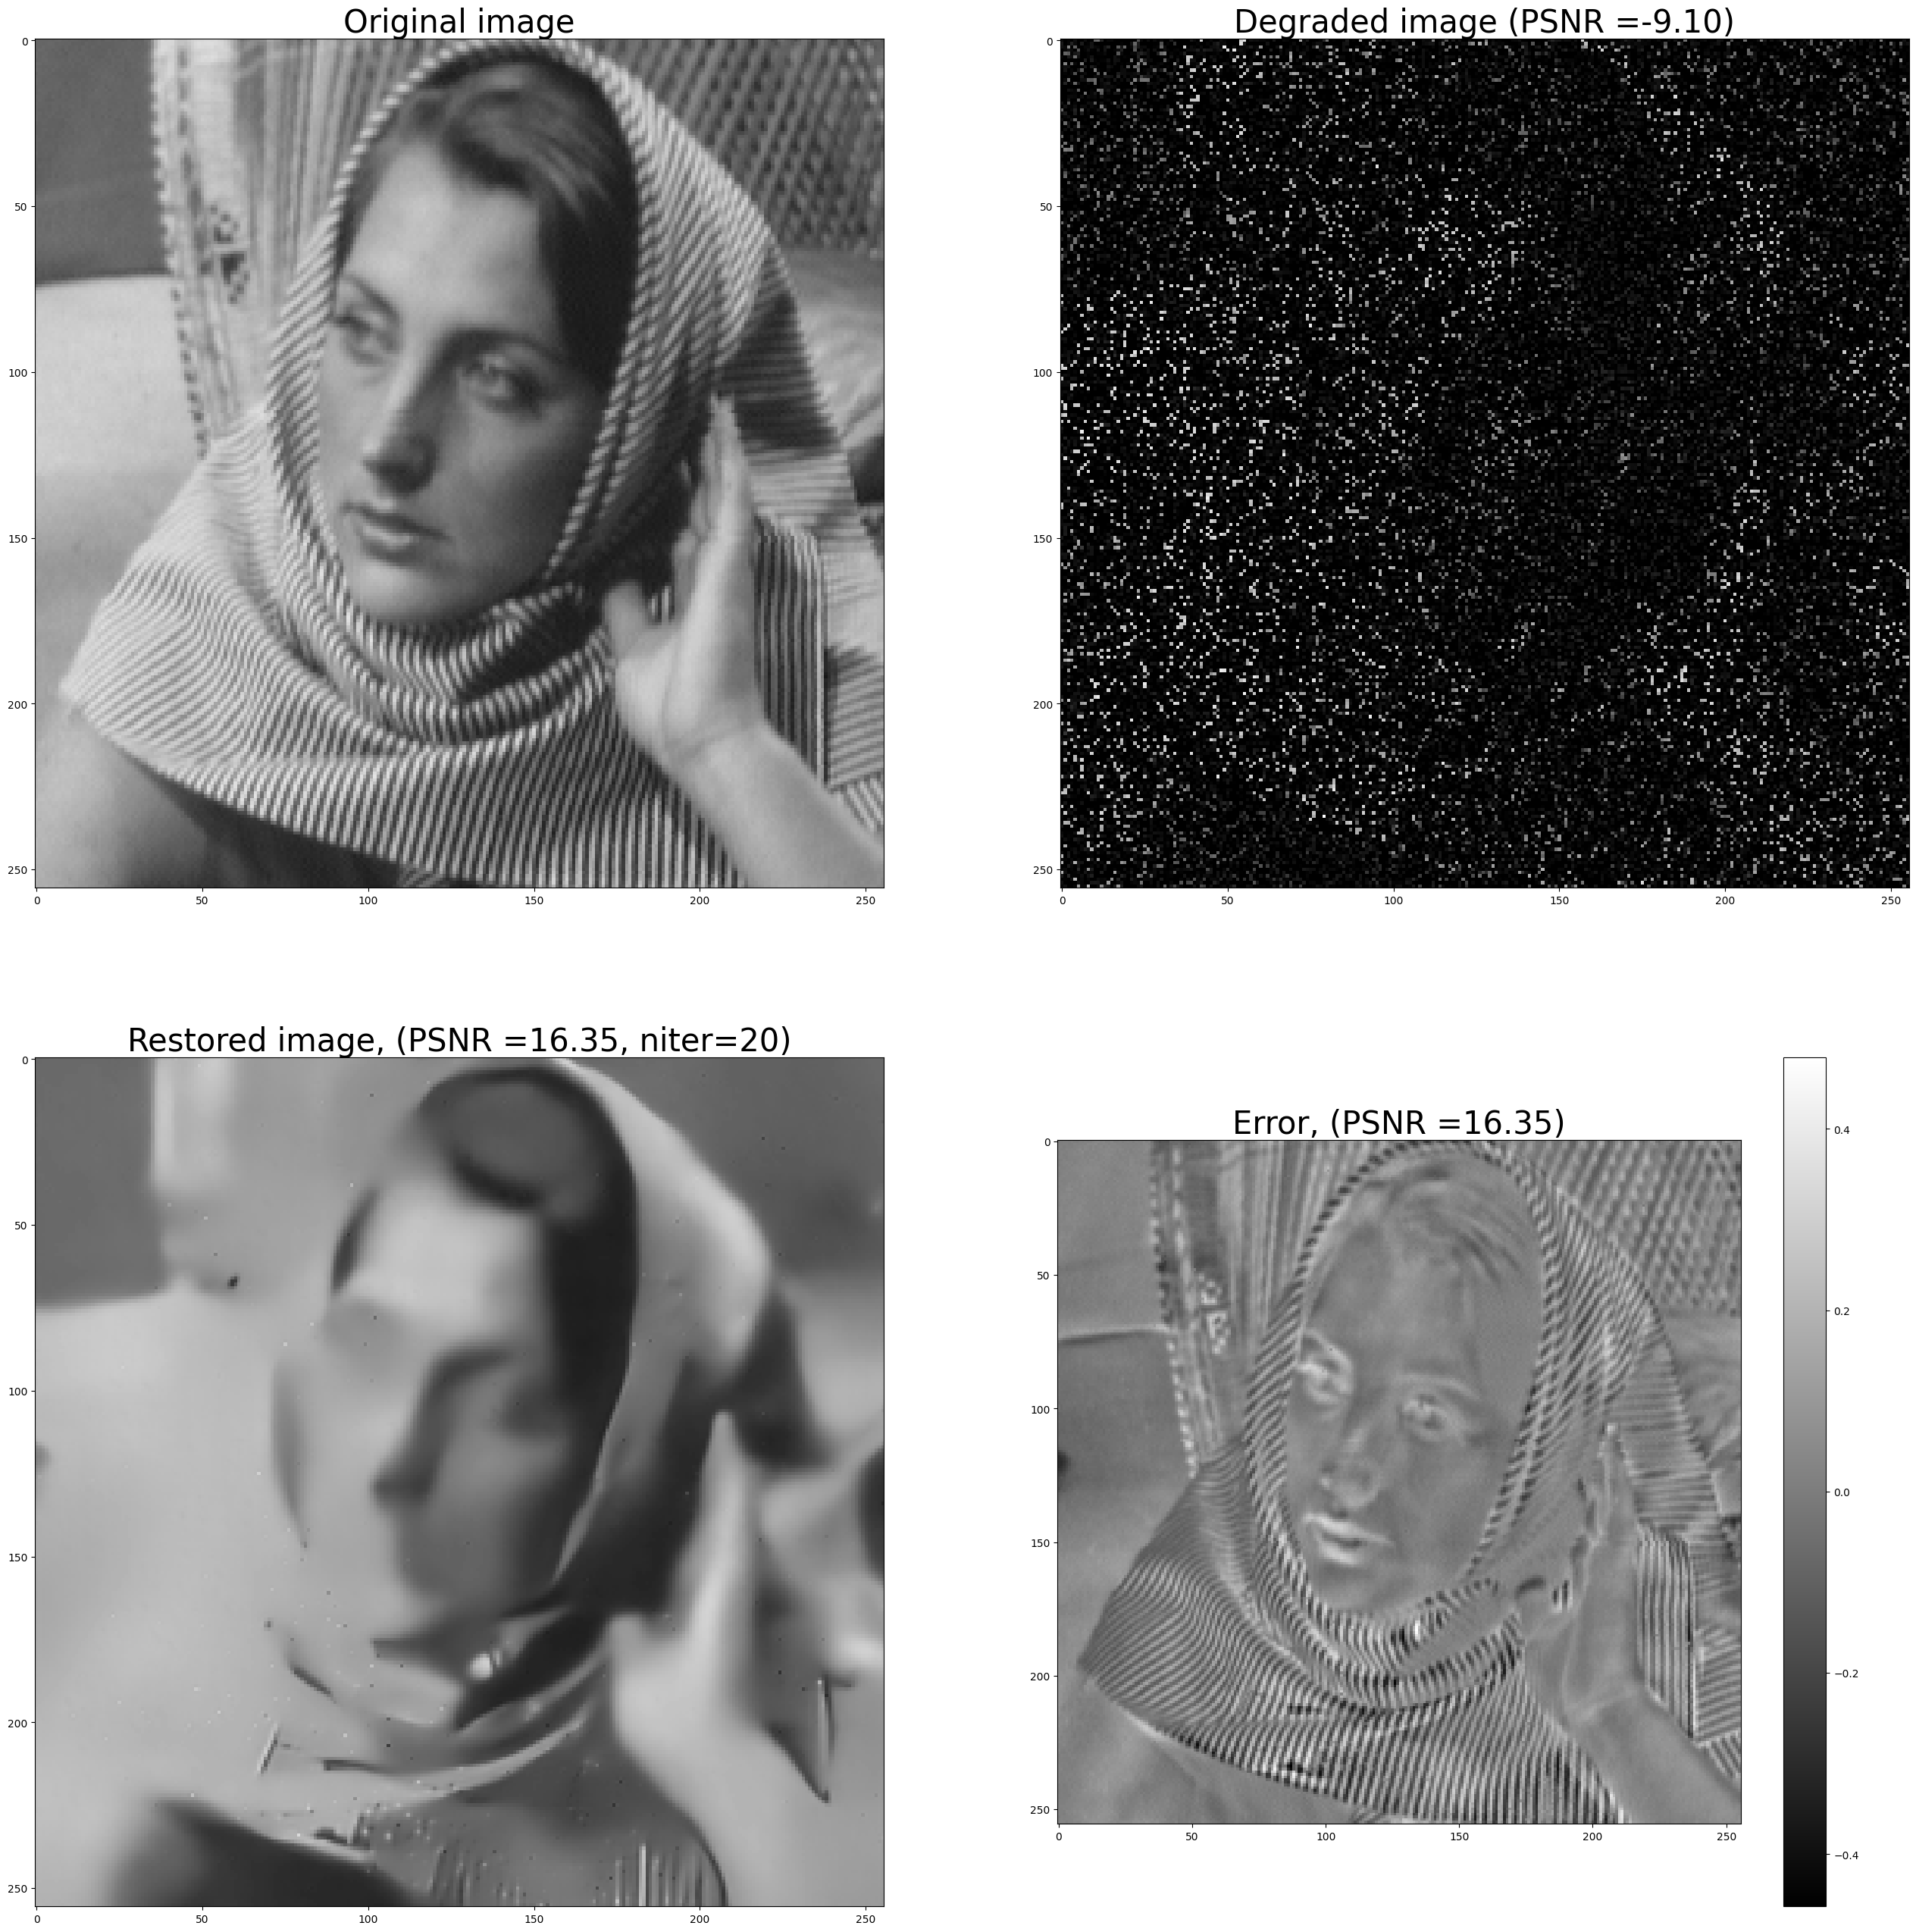

In [ ]:
alpha = sigma1 ** 2 / best_gamma
proxF = lambda x: prox_datafit_inpainting(x, utilde, mask, alpha, s1)
out, factors = admm2(proxF, denoise, utilde, maxitr=maxitr, verbose=verbose)

#%% ---- plot result ----
fig = plt.figure(figsize = (32,32))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(u, cmap = 'gray', vmin=0, vmax = 1)
ax1.set_title('Original image', fontsize = 30)

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(utilde, cmap = 'gray', vmin=0, vmax = 1)
ax2.set_title('Degraded image (PSNR ={0:.2f})'.format(psnr(u, utilde)), fontsize = 30)

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(out, cmap ='gray', vmin= 0, vmax=1)
ax3.set_title('Restored image, (PSNR ={0:.2f}, niter={1})'.format(psnr(u, out),maxitr), fontsize = 30)

ax4 = fig.add_subplot(2,2,4)
p = ax4.imshow(out-u, cmap ='gray')
plt.colorbar(p,orientation='vertical')
_ = ax4.set_title('Error, (PSNR ={0:.2f})'.format(psnr(u, out)), fontsize = 30)

# BONUS (optional)

## BONUS: Deblurring (optional)


Now you shall use your code to solve a new inverse problem: Image deblurring with Gaussian noise

In this case $A(\x) = \x*\mathbf{h} = (\sum_j x_{i-j} h_{j})_i$ where $\mathbf{h}$ is a known convolution kernel for instance a gaussian kernel or a box filter, and

$$F(\x)=\|A(\x)-\y\|^2\frac{1}{2s^2}$$

> _**QUESTION 10 (optional)** Add the code needed to simulate this new degradation._

In order to solve this inverse problem within the PnP ADMM framework you need to write a function that implements the proximal operator of the data-fitting term $F$  multiplied by $\alpha$  namely

$$ \prox_{\alpha F}(\z) = \arg\min_\x \alpha F(\x) + \frac{1}{2} \| \x - \z \|_2^2 $$

> _**QUESTION 11 (optional)**: Show that in this case this minimization can be solved in closed form (in the Fourier domain), and use this closed form to write the proximal operator of the data fitting term._

Provide your reconstruction results for deblurring with a Gaussian kernel with standard deviation $5$ and white Gaussian noise with $s=5$.

$\newcommand{\k}{\mathbf{k}}$
$\newcommand{\khat}{\hat{\k}}$
$\newcommand{\hhat}{\hat{\mathbf{h}}}$

> _**QUESTION 12 (optional)**: A simple way to provide a good initialization is to compute the Wiener filter for some reasonable prior._

Let $\xhat$ be the discrete Fourier transform of $\x$.

As a simple prior you can assume that the Fourier coefficients are independent and that they follow  a zero-mean Gaussian distribution $|\xhat_m| \sim N(0,F(|m|)^2)$ where $F(r)$ is a decreasing function of the frequency modulus.

This model is commonly used $F(r) = C (a+r)^{-p}$ where $a\approx 1$, $p\in[1,2]$. Find the values of $C, a$ and $p$ that best fit your image and use this as a prior for $\x$.

Under this prior the Wiener filter (the linear estimator which minimizes the quadratic risk) can be shown to be obtained as the convolution $\k*\xtilde$ where the deconvolution kernel is computed in the Fourier domain as:

$\khat_m = \frac{\overline{\hhat}_m|F(|m|)^2}{|\hhat_m|^2||F(|m|)|^2+\sigma^2}$






## BONUS: PnP ISTA (optional)


The Plug & Play ISTA algorithm presented in the lecture (Xu et al 2020) seeks to solve

$$ \hat{x} = \arg\min_x F(x) + \gamma G(x) $$

of equivalently (for $\gamma = \sigma^2/\alpha$):

$$ \hat{x} = \arg\min_x \alpha F(x) + \sigma^2 G(x) $$

by running the following splitting scheme

* $v_k = x_k - \nabla(\alpha F)(x_k)$         (gradient descent step)
* $x_{k+1} = \prox_{\sigma^2 G}(v_k) = D_{\delta\sigma^2}(v_k)$   (proximal descent step)

Convergence is ensured as long as

* $D_{\sigma^2}$ is an MMSE denoiser and
* $\alpha < 1 / Lip(\nabla F)$



> _**QUESTION 13 (optional):** Complete the code below to compute the pnp ista algorithm find the condition on $\gamma$ to garantee the convergence of PnP ISTA find the optimal $\gamma$ for $\sigma = 40, 15, 5$ does it satisfy the convergence condition ? For which $\sigma$ do you obtain the best reconstruction ?_



In [48]:
def ista(gradF,proxG,init,**opts):
    """
    ISTA - min_x F(x) + G(x) by Proximal-gradient splitting

    v_k     = x_k - gradF(x_k)
    x_{k+1} = proxG(v_k)

    Convergence Condition: delta = 1 < 1/ Lip(gradF)

    Inputs:
        :gradF      gradient of F
        :proxG      Proximal operator of G
        :init       Initial value of x
        :delta      gradient descent step (default 1)
    Optional inputs
        :maxitr     default 50
        :verbose    default 1 (show messages)
    Outputs
        :x          minimizer
    """

    """ Process parameters. """
    maxitr = opts.get('maxitr', 50)
    verbose = opts.get('verbose', 1)
    monitor  = opts.get('monitor', None)  # debugging messages


    """ Initialization. """

    n = init.size  # == np.prod(init.shape), i.e. number of elements in ndarray

    x = np.copy(init)
    v = np.zeros_like(init, dtype=np.float64)

    """ Main loop. """

    for i in range(maxitr):

        # record the variables in the current iteration
        x_old = np.copy(x)
        v_old = np.copy(v)

        """ gradient descent step. """

        v = x - gradF(x) # COMPLETE

        """ proximal descent step. """

        x = proxG(v) # COMPLETE

        """ Monitors """

        if verbose :
            print("i = {},\t fpr = {}".format(i+1, np.linalg.norm(x-x_old)/np.linalg.norm(x)))


    """ Get restored image. """
    return x


def grad_datafit_gaussian_denoising(x, y, alpha=1.0, s=1.0):
    """
    Gradient Operator for Gaussian denoising:

    f(x) = || x - y ||^2 / (2 s^2)

    grad {alpha f} (x) = (x - y)*alpha/s^2

    Parameters:
        :x - the argument to the proximal operator.
        :y - the noisy observation (flattened).
        :opts - the kwargs for hyperparameters.
            :alpha - the value of alpha.
            :s - the standard deviation of the gaussian noise in y.
    """
    v = np.copy((x-y)*alpha/(s**2))
    return v

monitor = GaussianMonitor(u)
model_type='RealSN_DnCNN'
# Simulate degraded image utilde
s1 = 30 / 255  # Standard deviation for noise
noise = np.random.normal(loc=0, scale=s1, size=u.shape)
utilde = u + noise

# PnP ADMM restoration
sigma255=40
sigma1 = sigma255 / 255
gamma0 = sigma1 / s1
maxitr = 20
verbose = 0

# Maximal (theoretical) gamma
mu = 1.0/(s1**2)
eps = 0.464 # RealSN_DnCNN
#eps = 1.198 # BM3D
# gamma_max = mu*(sigma1**2)*(1.0+eps-2*(eps**2))/eps

# geometric mean
gmean = lambda a: np.exp(np.mean(np.log(a)))

init = utilde
print('Theoretical gamma max = {:.3e}'.format(gamma_max))
#####
best_gama,_ = get_best_gamma(utilde, u, 100, sigma255, s1, model_type='DnCNN' , init = init)
print('Empirical bes gamma is: ', best_gama)
Denoiser = PyTorchDenoiser(model_type,sigma255,cuda,rescale)
denoise = lambda x: Denoiser.denoise(x)
gamma = best_gama * factor
alpha = sigma1 ** 2 / gamma

gradF = lambda x : grad_datafit_gaussian_denoising(x, utilde, alpha,s1)
out= ista(gradF, denoise, init, maxitr=maxitr, verbose=verbose)
# Calculate metrics
psnr_value = psnr(u, out)
rmse_value = rmse(u, out)

print(f"Best  empirical Gamma: {best_gama},  PSNR: {psnr_value},  RMSE: {rmse_value}")



Theoretical gamma max = 2.227e+00
Empirical bes gamma is:  1.3333333333333333
Best  empirical Gamma: 1.3333333333333333,  PSNR: 13.596917126241328,  RMSE: 0.11066995831789077


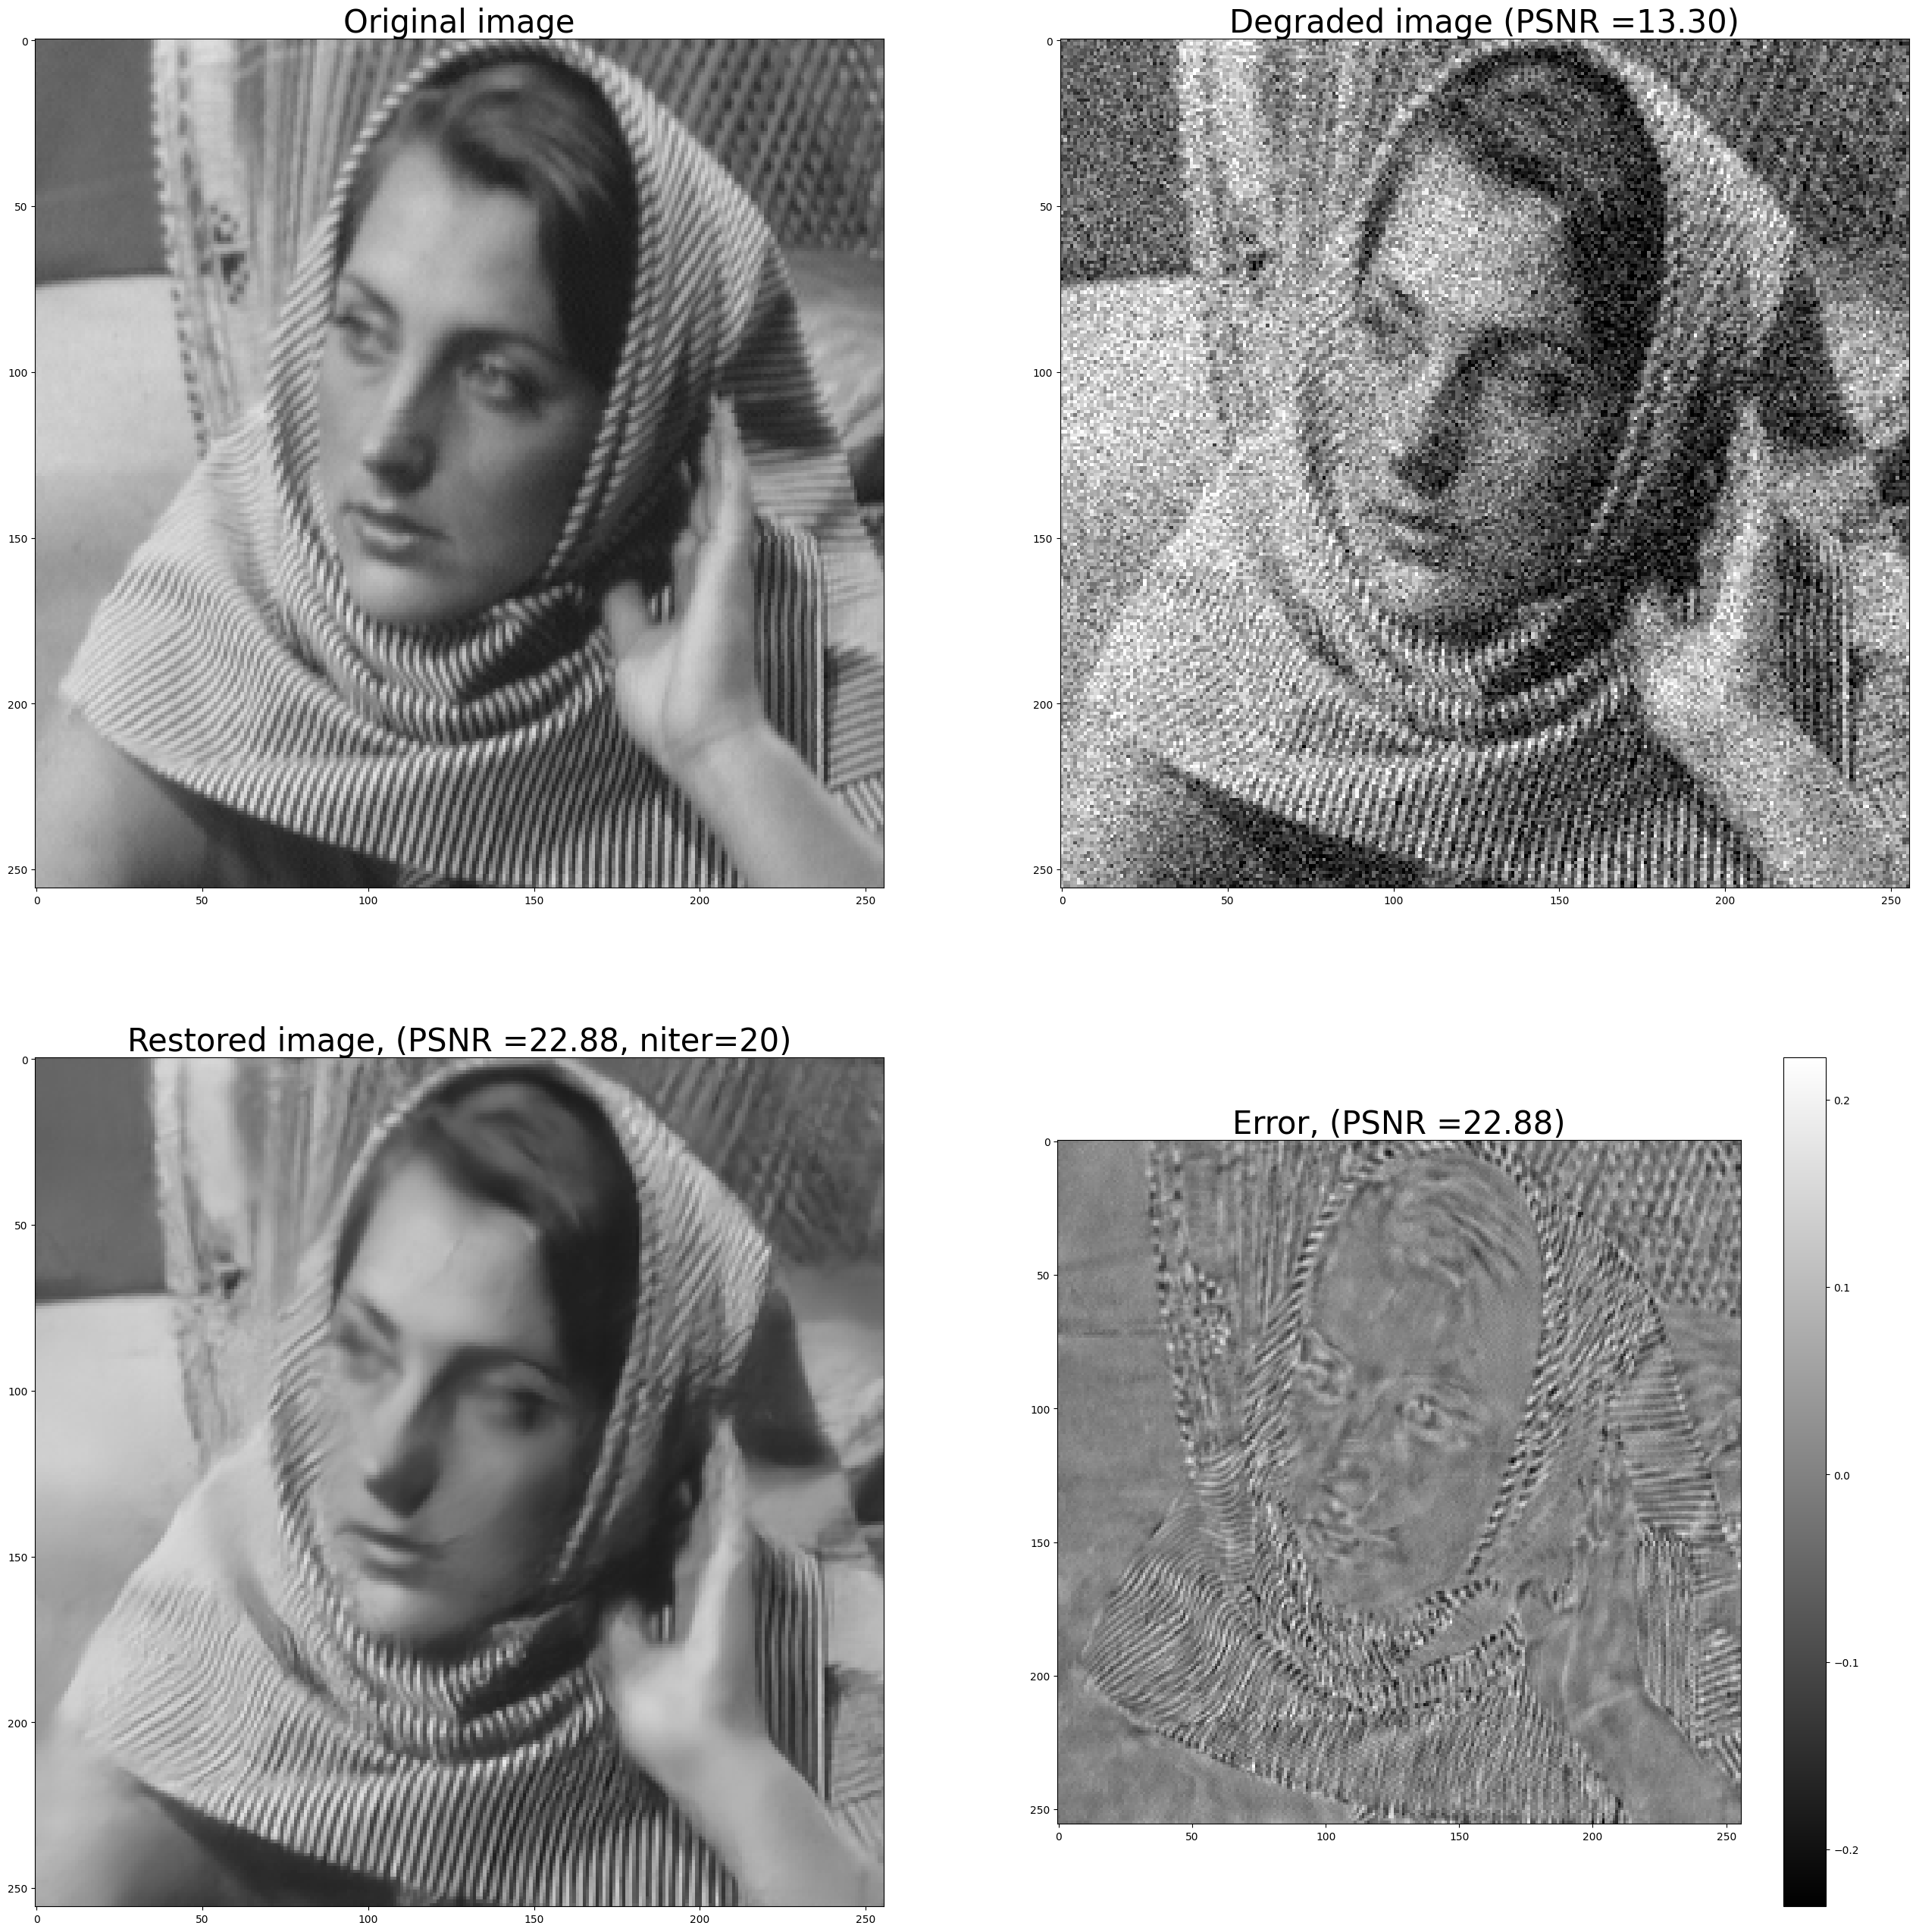

In [47]:
alpha = sigma1 ** 2 / best_gama
gradF = lambda x: grad_datafit_gaussian_denoising(x, utilde, alpha, s1)
out= ista(gradF, denoise, init, maxitr=maxitr, verbose=verbose)

#%% ---- plot result ----
fig = plt.figure(figsize = (32,32))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(u, cmap = 'gray', vmin=0, vmax = 1)
ax1.set_title('Original image', fontsize = 30)

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(utilde, cmap = 'gray', vmin=0, vmax = 1)
ax2.set_title('Degraded image (PSNR ={0:.2f})'.format(psnr(u, utilde)), fontsize = 30)

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(out, cmap ='gray', vmin= 0, vmax=1)
ax3.set_title('Restored image, (PSNR ={0:.2f}, niter={1})'.format(psnr(u, out),maxitr), fontsize = 30)

ax4 = fig.add_subplot(2,2,4)
p = ax4.imshow(out-u, cmap ='gray')
plt.colorbar(p,orientation='vertical')
_ = ax4.set_title('Error, (PSNR ={0:.2f})'.format(psnr(u, out)), fontsize = 30)